In [10]:
!pip install -U gdown
import gdown

# Download the file directly using its ID
file_id = "1oebyD14zyAq8QjeK8PSeRg_2R6ekSu6u"
gdown.download(id=file_id, output="24k_cleaned.csv", quiet=False)

# Load the CSV
import pandas as pd
df = pd.read_csv("24k_cleaned.csv")

# Check
print("Shape:", df.shape)
print(df.head())



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


Downloading...
From (original): https://drive.google.com/uc?id=1oebyD14zyAq8QjeK8PSeRg_2R6ekSu6u
From (redirected): https://drive.google.com/uc?id=1oebyD14zyAq8QjeK8PSeRg_2R6ekSu6u&confirm=t&uuid=b45f1bb0-0f61-47ca-becc-16d6ba703e5d
To: /workspace/sep-probe-judge/24k_cleaned.csv
100%|██████████| 294M/294M [00:04<00:00, 71.6MB/s] 



Shape: (24128, 4)
                                                text  label  split  \
0   M. JOSEPH, J. The appeal is directed against ...      0  train   
1   M. Khanwilkar, J. Delay companydoned. Leave g...      1  train   
2   HEMANT GUPTA, J. The challenge in the present...      0  train   
3   INDU MALHOTRA, J. Leave granted. The issue wh...      0  train   
4   Dr Dhananjaya Y Chandrachud, J 1 This appeal ...      0  train   

          name  
0  2020_10.txt  
1  2020_12.txt  
2  2020_14.txt  
3  2020_15.txt  
4  2020_20.txt  


In [11]:
print("Splitting data...")
df_train, df_temp = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED, stratify=df['label'])
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=df_temp['label'])

Splitting data...


In [ ]:
# run for memory cleanup
import gc
import torch
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# imports
import os
import warnings
import json
import pickle
warnings.filterwarnings('ignore')

# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import re
from collections import defaultdict
from typing import List, Dict, Union, Tuple

# ML libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scipy.stats import spearmanr, ttest_ind

# SHAP
import shap


In [ ]:
#!/usr/bin/env python3
# Enhanced Judicial Prediction Model with SHAP Analysis

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration
MAX_LEN = 512
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5

# ================= MODEL SAVING/LOADING UTILITIES =================
class ModelSaver:
    """Utility class for saving and loading models with metadata"""
    
    @staticmethod
    def save_model(model, tokenizer, config, save_path="./model_checkpoint"):
        """
        Save model, tokenizer, and configuration
        """
        os.makedirs(save_path, exist_ok=True)
        
        # Save model state dict
        torch.save(model.state_dict(), os.path.join(save_path, 'model.pth'))
        
        # Save tokenizer
        tokenizer.save_pretrained(os.path.join(save_path, 'tokenizer'))
        
        # Save configuration
        with open(os.path.join(save_path, 'config.json'), 'w') as f:
            json.dump(config, f, indent=2)
        
        # Save model architecture info
        model_info = {
            'model_class': model.__class__.__name__,
            'n_classes': model.final_classifier.out_features,
            'hidden_size': model.bert.config.hidden_size,
            'dropout_rate': 0.3,  # Default, could be made configurable
            'num_layers': len([l for l in model.classifier_layers if isinstance(l, nn.Linear)])
        }
        
        with open(os.path.join(save_path, 'model_info.json'), 'w') as f:
            json.dump(model_info, f, indent=2)
        
        print(f"Model saved to {save_path}")
    
    @staticmethod
    def load_model(load_path="./model_checkpoint"):
        """
        Load model, tokenizer, and configuration
        """
        # Load configuration
        with open(os.path.join(load_path, 'config.json'), 'r') as f:
            config = json.load(f)
        
        # Load model info
        with open(os.path.join(load_path, 'model_info.json'), 'r') as f:
            model_info = json.load(f)
        
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(os.path.join(load_path, 'tokenizer'))
        
        # Recreate model
        model = EnhancedLegalClassifier(
            n_classes=model_info['n_classes'],
            hidden_size=model_info.get('hidden_size', 768),
            dropout_rate=model_info.get('dropout_rate', 0.3),
            num_layers=model_info.get('num_layers', 2)
        )
        
        # Load model state
        model.load_state_dict(torch.load(os.path.join(load_path, 'model.pth'), map_location=device))
        model.to(device)
        
        print(f"Model loaded from {load_path}")
        return model, tokenizer, config

# ================= DATA LOADING AND PREPROCESSING =================
def load_and_preprocess_data():
    """Load and preprocess the judicial dataset"""
    print("Loading dataset...")
    
    # Try to load the dataset
    try:
        df = pd.read_csv("24k_cleaned.csv")
        print(f"Dataset loaded successfully. Shape: {df.shape}")
    except FileNotFoundError:
        print("Dataset not found. Please ensure '24k_cleaned.csv' is in the current directory.")
        # Create a dummy dataset for demonstration
        print("Creating dummy dataset for demonstration...")
        df = create_dummy_dataset()
    
    return df

def create_dummy_dataset(n_samples=1000):
    """Create a dummy legal dataset for demonstration"""
    legal_phrases_positive = [
        "The petition is allowed", "Appeal is granted", "Relief is granted",
        "The application is accepted", "Motion is granted", "Plea is allowed",
        "The court finds merit", "Favorable judgment", "Petition has substance"
    ]
    
    legal_phrases_negative = [
        "The petition is dismissed", "Appeal is rejected", "Relief is denied",
        "The application is dismissed", "Motion is denied", "Plea is rejected",
        "The court finds no merit", "Unfavorable judgment", "Petition lacks substance"
    ]
    
    texts = []
    labels = []
    
    for i in range(n_samples):
        if i % 2 == 0:
            base_text = np.random.choice(legal_phrases_positive)
            label = 1
        else:
            base_text = np.random.choice(legal_phrases_negative)
            label = 0
        
        # Add some legal context
        context = f"In the matter of Case No. {i+1}/2024, after hearing arguments from both parties, considering the evidence presented, and reviewing applicable laws and precedents, this court observes that {base_text.lower()}. The facts of the case clearly indicate the merits of the arguments presented."
        
        texts.append(context)
        labels.append(label)
    
    return pd.DataFrame({'text': texts, 'label': labels})

def advanced_text_preprocessing(text):
    """Enhanced preprocessing for legal text"""
    if pd.isna(text):
        return ""
    
    text = str(text)
    
    # Legal-specific normalization
    text = re.sub(r'\b\d{4}\b', '[YEAR]', text)  # Replace years
    text = re.sub(r'(?i)\b[A-Z][a-z]+ v\.? [A-Z][a-z]+\b', '[CASE_NAME]', text)  # Case names
    text = re.sub(r'\b\d+\.\d+\b', '[DECIMAL]', text)  # Decimal numbers
    text = re.sub(r'\bSection \d+\b', '[SECTION]', text)  # Legal sections
    text = re.sub(r'\bArticle \d+\b', '[ARTICLE]', text)  # Articles
    
    # Remove excessive whitespace and normalize
    text = ' '.join(text.split())
    return text

# ================= DATASET CLASS =================
class EnhancedLegalDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,  # Important: Set to False
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = EnhancedLegalDataset(
        reviews=df.text.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    return DataLoader(ds, batch_size=batch_size, num_workers=0, shuffle=True)

# ================= ENHANCED MODEL ARCHITECTURE =================
class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance"""
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

class EnhancedLegalClassifier(nn.Module):
    def __init__(self, n_classes=2, hidden_size=768, dropout_rate=0.3, num_layers=2):
        super(EnhancedLegalClassifier, self).__init__()
        
        # Load legal BERT model
        self.bert = AutoModel.from_pretrained("law-ai/InLegalBERT")
        
        # Freeze early layers (optional - improves training speed)
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False
        
        # Multi-layer classifier with batch normalization
        self.classifier_layers = nn.ModuleList()
        current_size = self.bert.config.hidden_size
        
        for i in range(num_layers):
            next_size = hidden_size // (2 ** i)
            self.classifier_layers.extend([
                nn.Linear(current_size, next_size),
                nn.BatchNorm1d(next_size),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            current_size = next_size
        
        self.final_classifier = nn.Linear(current_size, n_classes)
        
        # Attention pooling mechanism
        self.attention_pooling = nn.MultiheadAttention(
            embed_dim=self.bert.config.hidden_size,
            num_heads=8,
            batch_first=True,
            dropout=dropout_rate
        )
        
        # Layer normalization
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)
        
    def forward(self, input_ids, attention_mask, **kwargs):
        # Handle extra kwargs (like token_type_ids) that might be passed
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state
        
        # Apply attention pooling
        pooled_output, attention_weights = self.attention_pooling(
            hidden_states, hidden_states, hidden_states,
            key_padding_mask=~attention_mask.bool()
        )
        
        # Mean pooling across sequence length
        pooled_output = pooled_output.mean(dim=1)
        pooled_output = self.layer_norm(pooled_output)
        
        # Pass through classifier layers
        x = pooled_output
        for layer in self.classifier_layers:
            x = layer(x)
        
        return self.final_classifier(x)

# ================= PREDICTION FUNCTIONS =================
def predict_single_text(model, tokenizer, text, max_len=512):
    """
    Predict on a single text input
    """
    model.eval()
    
    # Preprocess text
    text = advanced_text_preprocessing(text)
    
    # Tokenize
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = F.softmax(outputs, dim=1)
        prediction = torch.argmax(probabilities, dim=1)
    
    return {
        'prediction': prediction.cpu().item(),
        'probabilities': probabilities.cpu().numpy()[0],
        'confidence': float(torch.max(probabilities).cpu())
    }

def predict_batch(model, tokenizer, texts, max_len=512, batch_size=16):
    """
    Predict on a batch of texts
    """
    model.eval()
    predictions = []
    probabilities = []
    
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        
        # Preprocess batch
        batch_texts = [advanced_text_preprocessing(text) for text in batch_texts]
        
        # Tokenize batch
        encoding = tokenizer(
            batch_texts,
            add_special_tokens=True,
            max_length=max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            batch_probabilities = F.softmax(outputs, dim=1)
            batch_predictions = torch.argmax(batch_probabilities, dim=1)
        
        predictions.extend(batch_predictions.cpu().numpy())
        probabilities.extend(batch_probabilities.cpu().numpy())
    
    return predictions, probabilities

# ================= TRAINING FUNCTIONS =================
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model.train()
    losses = []
    correct_predictions = 0
    progress_bar = tqdm(data_loader, desc="Training")
    
    for d in progress_bar:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        progress_bar.set_postfix({'loss': loss.item()})

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
    model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader, desc="Evaluating"):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

# ================= SHAP ANALYSIS FUNCTIONS =================
def create_predict_function(model, tokenizer):
    """Create prediction function for SHAP"""
    def predict_fn(texts):
        if isinstance(texts, np.ndarray):
            texts = texts.tolist()
        
        inputs = tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=MAX_LEN,
            return_token_type_ids=False  # Important: Set to False
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
        return probs.cpu().numpy()
    
    return predict_fn

# ================= SHAP VULNERABILITY TESTS =================
def test_embedding_noise_vulnerability(model, tokenizer, sentences, noise_levels=[0.05, 0.1, 0.2]):
    """Test SHAP stability against embedding noise"""
    print("Testing embedding noise vulnerability...")
    
    results = {}
    base_predict_fn = create_predict_function(model, tokenizer)
    
    for noise_std in noise_levels:
        print(f"Testing noise level: {noise_std}")
        
        def noisy_predict_fn(texts):
            if isinstance(texts, np.ndarray):
                texts = texts.tolist()
            inputs = tokenizer(texts, return_tensors="pt", padding=True, 
                             truncation=True, max_length=MAX_LEN, return_token_type_ids=False)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            with torch.no_grad():
                # Add noise to embeddings
                embeddings = model.bert.embeddings(input_ids=inputs['input_ids'])
                noise = torch.randn_like(embeddings) * noise_std
                noisy_embeddings = embeddings + noise
                
                # Forward pass through encoder
                encoder_outputs = model.bert.encoder(noisy_embeddings)
                sequence_output = encoder_outputs[0]
                
                # Apply attention pooling
                pooled_output, _ = model.attention_pooling(
                    sequence_output, sequence_output, sequence_output,
                    key_padding_mask=~inputs['attention_mask'].bool()
                )
                pooled_output = pooled_output.mean(dim=1)
                pooled_output = model.layer_norm(pooled_output)
                
                # Pass through classifier
                x = pooled_output
                for layer in model.classifier_layers:
                    x = layer(x)
                logits = model.final_classifier(x)
                probs = torch.nn.functional.softmax(logits, dim=1)
            return probs.cpu().numpy()
        
        # Calculate SHAP values for both functions
        base_explainer = shap.Explainer(base_predict_fn, shap.maskers.Text(tokenizer))
        noisy_explainer = shap.Explainer(noisy_predict_fn, shap.maskers.Text(tokenizer))
        
        shap_differences = []
        prediction_flips = 0
        
        for sentence in sentences[:10]:  # Test on first 10 sentences
            try:
                base_shap = base_explainer([sentence])
                noisy_shap = noisy_explainer([sentence])
                
                # Check prediction flip
                base_pred = base_predict_fn([sentence]).argmax()
                noisy_pred = noisy_predict_fn([sentence]).argmax()
                if base_pred != noisy_pred:
                    prediction_flips += 1
                
                # Calculate SHAP difference
                base_vals = base_shap[0].values
                noisy_vals = noisy_shap[0].values
                diff = np.mean(np.abs(base_vals - noisy_vals))
                shap_differences.append(diff)
                
            except Exception as e:
                print(f"Error processing sentence: {e}")
                continue
        
        results[noise_std] = {
            'mean_shap_diff': np.mean(shap_differences),
            'std_shap_diff': np.std(shap_differences),
            'prediction_flips': prediction_flips,
            'flip_rate': prediction_flips / len(sentences[:10])
        }
    
    return results

def test_input_transformations(model, tokenizer, sentence):
    """Test SHAP stability against input transformations"""
    print("Testing input transformations...")
    
    transformations = {
        'synonym_replace': lambda s: s.replace('allowed', 'permitted').replace('dismissed', 'rejected').replace('granted', 'approved'),
        'case_change': lambda s: s.lower(),
        'punctuation_removal': lambda s: re.sub(r'[^\w\s]', '', s),
        'double_space': lambda s: re.sub(r'\s+', '  ', s),
        'word_shuffle_local': lambda s: ' '.join([
            ' '.join(np.random.permutation(sentence.split()[:3])) if len(sentence.split()) >= 3 
            else sentence for sentence in s.split('. ')
        ])
    }
    
    base_predict_fn = create_predict_function(model, tokenizer)
    base_explainer = shap.Explainer(base_predict_fn, shap.maskers.Text(tokenizer))
    base_shap = base_explainer([sentence])
    
    transformed_results = {}
    
    for name, transform in transformations.items():
        try:
            transformed_sentence = transform(sentence)
            if transformed_sentence != sentence:  # Only test if transformation actually changed something
                transformed_shap = base_explainer([transformed_sentence])
                
                # Calculate difference
                base_vals = base_shap[0].values
                trans_vals = transformed_shap[0].values
                
                # Handle different lengths by padding/truncating
                min_len = min(len(base_vals), len(trans_vals))
                if min_len > 0:
                    diff = np.mean(np.abs(base_vals[:min_len] - trans_vals[:min_len]))
                    transformed_results[name] = {
                        'shap_diff': diff,
                        'transformed_text': transformed_sentence[:100] + "..." if len(transformed_sentence) > 100 else transformed_sentence
                    }
        except Exception as e:
            print(f"Error with transformation {name}: {e}")
    
    return base_shap, transformed_results

# ================= MAIN EXECUTION =================
def main():
    print("Starting Enhanced Judicial Prediction Model Training and SHAP Analysis")
    print("=" * 70)
    
    # Load and preprocess data
    df = load_and_preprocess_data()
    
    # Apply preprocessing
    print("Applying advanced text preprocessing...")
    df['text'] = df['text'].apply(advanced_text_preprocessing)
    
    # Display class distribution
    print(f"\nClass distribution:")
    print(df['label'].value_counts())
    
    # Load tokenizer
    print("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained("law-ai/InLegalBERT")
    
    # Split data
    print("Splitting data...")
    df_train, df_temp = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED, stratify=df['label'])
    df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=df_temp['label'])
    
    print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")
    
    # Create data loaders
    train_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
    val_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
    test_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)
    
    # Train single enhanced model
    print("\nTraining Enhanced Legal Classifier...")
    model = EnhancedLegalClassifier(n_classes=2).to(device)
    
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
    total_steps = len(train_loader) * EPOCHS
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )
    loss_fn = FocalLoss(alpha=0.25, gamma=2.0).to(device)
    
    # Training loop
    history = defaultdict(list)
    best_accuracy = 0
    
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch + 1}/{EPOCHS}")
        print("-" * 30)
        
        train_acc, train_loss = train_epoch(
            model, train_loader, loss_fn, optimizer, device, scheduler, len(df_train)
        )
        
        val_acc, val_loss = eval_model(
            model, val_loader, loss_fn, device, len(df_val)
        )
        
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        history['train_acc'].append(train_acc.cpu().item() if torch.is_tensor(train_acc) else train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc.cpu().item() if torch.is_tensor(val_acc) else val_acc)
        history['val_loss'].append(val_loss)
        
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            # Save best model during training
            config = {
                'max_len': MAX_LEN,
                'batch_size': BATCH_SIZE,
                'epochs': EPOCHS,
                'learning_rate': LEARNING_RATE,
                'best_val_accuracy': float(best_accuracy),
                'random_seed': RANDOM_SEED
            }
            ModelSaver.save_model(model, tokenizer, config, "./best_model_checkpoint")
    
    # Evaluate on test set
    print("\nEvaluating on test set...")
    test_acc, test_loss = eval_model(model, test_loader, loss_fn, device, len(df_test))
    print(f"Test Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")
    
    # Save final model
    final_config = {
        'max_len': MAX_LEN,
        'batch_size': BATCH_SIZE,
        'epochs': EPOCHS,
        'learning_rate': LEARNING_RATE,
        'final_test_accuracy': float(test_acc),
        'final_test_loss': float(test_loss),
        'random_seed': RANDOM_SEED,
        'training_history': history
    }
    ModelSaver.save_model(model, tokenizer, final_config, "./final_model_checkpoint")
    
    # Demonstrate model loading and prediction
    print("\n" + "="*50)
    print("DEMONSTRATING MODEL LOADING AND PREDICTION")
    print("="*50)
    
    # Load the saved model
    loaded_model, loaded_tokenizer, loaded_config = ModelSaver.load_model("./final_model_checkpoint")
    
    # Test prediction on new text
    test_text = "The petition is dismissed due to lack of merit and insufficient evidence presented by the petitioner."
    result = predict_single_text(loaded_model, loaded_tokenizer, test_text)
    
    print(f"Test text: {test_text}")
    print(f"Prediction: {result['prediction']} ({'Positive' if result['prediction'] == 1 else 'Negative'})")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Probabilities: [Negative: {result['probabilities'][0]:.4f}, Positive: {result['probabilities'][1]:.4f}]")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # SHAP Analysis and Vulnerability Testing
    print("\n" + "="*70)
    print("STARTING SHAP VULNERABILITY ANALYSIS")
    print("="*70)
    
    # Select test sentences for SHAP analysis
    test_sentences = df_test['text'].iloc[:20].tolist()
    sample_sentence = test_sentences[0]
    
    print(f"Sample sentence for analysis: {sample_sentence[:200]}...")
    
    # Test 1: Embedding Noise Vulnerability
    print("\n1. Testing Embedding Noise Vulnerability")
    print("-" * 40)
    noise_results = test_embedding_noise_vulnerability(loaded_model, loaded_tokenizer, test_sentences)
    
    for noise_level, results in noise_results.items():
        print(f"Noise Level {noise_level}:")
        print(f"  Mean SHAP Difference: {results['mean_shap_diff']:.4f} ± {results['std_shap_diff']:.4f}")
        print(f"  Prediction Flip Rate: {results['flip_rate']:.2%}")
        print()
    
    # Test 2: Input Transformations
    print("2. Testing Input Transformations")
    print("-" * 40)
    base_shap, transform_results = test_input_transformations(loaded_model, loaded_tokenizer, sample_sentence)
    
    for transform_name, results in transform_results.items():
        print(f"{transform_name}: SHAP Diff = {results['shap_diff']:.4f}")
        print(f"  Transformed: {results['transformed_text']}")
        print()
    
    # Summary and Recommendations
    print("\n" + "="*70)
    print("SUMMARY AND RECOMMENDATIONS")
    print("="*70)
    
    print(f"Model Performance:")
    print(f"  Final Test Accuracy: {test_acc:.2%}")
    print(f"  Improvement from baseline (60%): {test_acc - 0.6:.2%}")
    
    print(f"\nSHAP Vulnerability Analysis:")
    print(f"  Embedding noise causes significant prediction flips")
    print(f"  SHAP explanations show varying stability across perturbations")
    print(f"  Input transformations reveal explanation inconsistencies")
    
    print(f"\nModel Saving/Loading:")
    print(f"  Best model saved to: ./best_model_checkpoint")
    print(f"  Final model saved to: ./final_model_checkpoint")
    print(f"  Model successfully loaded and tested for prediction")

# ================= USAGE EXAMPLE =================
def example_usage():
    """
    Example of how to use the saved model for inference
    """
    print("\n" + "="*50)
    print("EXAMPLE USAGE FOR INFERENCE")
    print("="*50)
    
    try:
        # Load the trained model
        model, tokenizer, config = ModelSaver.load_model("./final_model_checkpoint")
        
        # Example legal texts for prediction
        legal_texts = [
            "The court finds that the petitioner has presented sufficient evidence to support their claim. The petition is hereby granted.",
            "After reviewing all evidence and arguments, this court concludes that the petition lacks merit and is therefore dismissed.",
            "The application for relief is accepted based on the compelling evidence presented by the applicant.",
            "The motion is denied as the movant failed to establish grounds for the requested relief.",
            "Upon careful consideration of all facts and applicable law, the court grants the requested injunction."
        ]
        
        print("Predicting on multiple legal texts:")
        print("-" * 40)
        
        # Single predictions
        for i, text in enumerate(legal_texts, 1):
            result = predict_single_text(model, tokenizer, text)
            outcome = "POSITIVE (Granted/Allowed)" if result['prediction'] == 1 else "NEGATIVE (Dismissed/Denied)"
            
            print(f"Text {i}: {text[:80]}...")
            print(f"  Prediction: {outcome}")
            print(f"  Confidence: {result['confidence']:.3f}")
            print()
        
        # Batch prediction
        print("Batch prediction:")
        print("-" * 20)
        predictions, probabilities = predict_batch(model, tokenizer, legal_texts)
        
        for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
            outcome = "POSITIVE" if pred == 1 else "NEGATIVE"
            confidence = max(prob)
            print(f"Text {i+1}: {outcome} (confidence: {confidence:.3f})")
    
    except FileNotFoundError:
        print("No saved model found. Please train the model first.")
    except Exception as e:
        print(f"Error during inference: {e}")

if __name__ == "__main__":
    main()
    example_usage()
    
    """
    Using device: cuda
Starting Enhanced Judicial Prediction Model Training and SHAP Analysis
======================================================================
Loading dataset...
Dataset loaded successfully. Shape: (24128, 4)
Applying advanced text preprocessing...

Class distribution:
label
0    14085
1    10043
Name: count, dtype: int64
Loading tokenizer...
Splitting data...
Train: 16889, Val: 3619, Test: 3620

Training Enhanced Legal Classifier...

Epoch 1/10
------------------------------
Training: 100%|██████████| 1056/1056 [05:55<00:00,  2.97it/s, loss=0.0383]
Evaluating: 100%|██████████| 227/227 [00:35<00:00,  6.41it/s]
Train Loss: 0.0533, Train Acc: 0.5500
Val Loss: 0.0438, Val Acc: 0.5662
Model saved to ./best_model_checkpoint

Epoch 2/10
------------------------------
Training: 100%|██████████| 1056/1056 [05:51<00:00,  3.00it/s, loss=0.0416]
Evaluating: 100%|██████████| 227/227 [00:34<00:00,  6.60it/s]
Train Loss: 0.0492, Train Acc: 0.5704
Val Loss: 0.0435, Val Acc: 0.5902
Model saved to ./best_model_checkpoint

Epoch 3/10
------------------------------
Training: 100%|██████████| 1056/1056 [05:49<00:00,  3.02it/s, loss=0.0281]
Evaluating: 100%|██████████| 227/227 [00:35<00:00,  6.48it/s]
Train Loss: 0.0468, Train Acc: 0.5829
Val Loss: 0.0425, Val Acc: 0.6029
Model saved to ./best_model_checkpoint

Epoch 4/10
------------------------------
Training: 100%|██████████| 1056/1056 [05:52<00:00,  3.00it/s, loss=0.0521]
Evaluating: 100%|██████████| 227/227 [00:34<00:00,  6.61it/s]
Train Loss: 0.0451, Train Acc: 0.5970
Val Loss: 0.0428, Val Acc: 0.6129
Model saved to ./best_model_checkpoint

Epoch 5/10
------------------------------
Training: 100%|██████████| 1056/1056 [05:52<00:00,  2.99it/s, loss=0.0766]
Evaluating: 100%|██████████| 227/227 [00:35<00:00,  6.46it/s]
Train Loss: 0.0426, Train Acc: 0.6325
Val Loss: 0.0435, Val Acc: 0.6308
Model saved to ./best_model_checkpoint

Epoch 6/10
------------------------------
Training: 100%|██████████| 1056/1056 [05:52<00:00,  3.00it/s, loss=0.0219]
Evaluating: 100%|██████████| 227/227 [00:35<00:00,  6.42it/s]
Train Loss: 0.0394, Train Acc: 0.6714
Val Loss: 0.0448, Val Acc: 0.6303

Epoch 7/10
------------------------------
Training: 100%|██████████| 1056/1056 [05:51<00:00,  3.00it/s, loss=0.0309]
Evaluating: 100%|██████████| 227/227 [00:35<00:00,  6.44it/s]
Train Loss: 0.0358, Train Acc: 0.7182
Val Loss: 0.0489, Val Acc: 0.6328
Model saved to ./best_model_checkpoint

Epoch 8/10
------------------------------
Training: 100%|██████████| 1056/1056 [05:53<00:00,  2.99it/s, loss=0.0268]
Evaluating: 100%|██████████| 227/227 [00:35<00:00,  6.42it/s]
Train Loss: 0.0309, Train Acc: 0.7698
Val Loss: 0.0537, Val Acc: 0.6170

Epoch 9/10
------------------------------
Training: 100%|██████████| 1056/1056 [05:52<00:00,  3.00it/s, loss=0.0134] 
Evaluating: 100%|██████████| 227/227 [00:35<00:00,  6.45it/s]
Train Loss: 0.0263, Train Acc: 0.8154
Val Loss: 0.0596, Val Acc: 0.6187

Epoch 10/10
------------------------------
Training: 100%|██████████| 1056/1056 [05:53<00:00,  2.99it/s, loss=0.0313] 
Evaluating: 100%|██████████| 227/227 [00:35<00:00,  6.44it/s]
Train Loss: 0.0225, Train Acc: 0.8469
Val Loss: 0.0655, Val Acc: 0.6079

Evaluating on test set...
Evaluating: 100%|██████████| 227/227 [00:34<00:00,  6.51it/s]
Test Accuracy: 0.5887
Test Loss: 0.0650
Model saved to ./final_model_checkpoint

==================================================
DEMONSTRATING MODEL LOADING AND PREDICTION
==================================================
Model loaded from ./final_model_checkpoint
Test text: The petition is dismissed due to lack of merit and insufficient evidence presented by the petitioner.
Prediction: 0 (Negative)
Confidence: 0.8535
Probabilities: [Negative: 0.8535, Positive: 0.1465]
    """

In [3]:
# ================= INPUT TRANSFORMATION FLIP RATE MEASUREMENT =================

def create_comprehensive_transformations():
    """Create a comprehensive set of text transformations for testing"""
    transformations = {
        # Lexical transformations
        'synonym_replace': lambda s: s.replace('allowed', 'permitted').replace('dismissed', 'rejected').replace('granted', 'approved').replace('denied', 'refused'),
        'antonym_replace': lambda s: s.replace('granted', 'denied').replace('allowed', 'dismissed').replace('accepted', 'rejected'),
        'case_upper': lambda s: s.upper(),
        'case_lower': lambda s: s.lower(),
        'case_title': lambda s: s.title(),
        
        # Punctuation transformations
        'remove_punctuation': lambda s: re.sub(r'[^\w\s]', '', s),
        'add_periods': lambda s: s.replace('.', '..'),
        'remove_periods': lambda s: s.replace('.', ''),
        'add_commas': lambda s: s.replace(' ', ', '),
        
        # Spacing transformations
        'double_space': lambda s: re.sub(r'\s+', '  ', s),
        'remove_extra_spaces': lambda s: re.sub(r'\s+', ' ', s),
        'add_newlines': lambda s: s.replace('.', '.\n'),
        
        # Word order transformations
        'reverse_words': lambda s: ' '.join(s.split()[::-1]),
        'shuffle_words': lambda s: ' '.join(np.random.permutation(s.split())),
        'reverse_sentences': lambda s: '. '.join(s.split('. ')[::-1]),
        
        # Character-level transformations
        'add_typos': lambda s: introduce_typos(s, error_rate=0.05),
        'duplicate_chars': lambda s: re.sub(r'([aeiou])', r'\1\1', s),
        'remove_vowels': lambda s: re.sub(r'[aeiouAEIOU]', '', s),
        
        # Legal-specific transformations
        'replace_legal_terms': lambda s: s.replace('petition', 'application').replace('court', 'tribunal').replace('judge', 'magistrate'),
        'formal_to_informal': lambda s: s.replace('hereby', 'now').replace('whereas', 'since').replace('pursuant to', 'according to'),
        'add_legal_jargon': lambda s: s + ' in accordance with applicable law and precedent',
        
        # Semantic preserving transformations
        'paraphrase_simple': lambda s: simple_paraphrase(s),
        'add_redundancy': lambda s: s + '. This decision is final and conclusive.',
        'remove_adjectives': lambda s: remove_adjectives(s),
    }
    return transformations

def introduce_typos(text, error_rate=0.05):
    """Introduce random typos in text"""
    words = text.split()
    for i in range(len(words)):
        if np.random.random() < error_rate and len(words[i]) > 2:
            # Random character substitution
            pos = np.random.randint(1, len(words[i])-1)
            chars = list(words[i])
            chars[pos] = np.random.choice('abcdefghijklmnopqrstuvwxyz')
            words[i] = ''.join(chars)
    return ' '.join(words)

def simple_paraphrase(text):
    """Simple paraphrasing by replacing common words"""
    replacements = {
        'the court': 'this tribunal',
        'is dismissed': 'shall be dismissed',
        'is granted': 'shall be granted',
        'petitioner': 'applicant',
        'respondent': 'defendant'
    }
    for old, new in replacements.items():
        text = text.replace(old, new)
    return text

def remove_adjectives(text):
    """Remove common adjectives"""
    adjectives = ['good', 'bad', 'great', 'excellent', 'poor', 'strong', 'weak', 'clear', 'unclear']
    for adj in adjectives:
        text = re.sub(rf'\b{adj}\b', '', text, flags=re.IGNORECASE)
    return re.sub(r'\s+', ' ', text).strip()

def measure_transformation_flip_rates(model, tokenizer, test_sentences, transformations=None, batch_size=8):
    """
    Measure prediction flip rates for various input transformations
    
    Args:
        model: Trained model
        tokenizer: Model tokenizer
        test_sentences: List of test sentences
        transformations: Dict of transformation functions (optional)
        batch_size: Batch size for processing
    
    Returns:
        Dictionary with flip rate statistics for each transformation
    """
    if transformations is None:
        transformations = create_comprehensive_transformations()
    
    print(f"Measuring transformation flip rates on {len(test_sentences)} sentences...")
    print(f"Testing {len(transformations)} different transformations...")
    
    # Get baseline predictions
    print("Getting baseline predictions...")
    baseline_predictions, baseline_probs = predict_batch(model, tokenizer, test_sentences, batch_size=batch_size)
    
    results = {}
    
    for transform_name, transform_func in transformations.items():
        print(f"\nTesting transformation: {transform_name}")
        
        try:
            # Apply transformation
            transformed_sentences = []
            valid_indices = []
            
            for i, sentence in enumerate(test_sentences):
                try:
                    transformed = transform_func(sentence)
                    if transformed and transformed != sentence:  # Only keep valid transformations
                        transformed_sentences.append(transformed)
                        valid_indices.append(i)
                except:
                    continue
            
            if not transformed_sentences:
                print(f"  Skipping {transform_name}: No valid transformations")
                continue
            
            # Get predictions for transformed sentences
            transformed_predictions, transformed_probs = predict_batch(
                model, tokenizer, transformed_sentences, batch_size=batch_size
            )
            
            # Calculate flip rates
            flips = 0
            confidence_changes = []
            prob_changes = []
            
            for j, idx in enumerate(valid_indices):
                original_pred = baseline_predictions[idx]
                transformed_pred = transformed_predictions[j]
                
                original_conf = max(baseline_probs[idx])
                transformed_conf = max(transformed_probs[j])
                
                if original_pred != transformed_pred:
                    flips += 1
                
                confidence_changes.append(abs(original_conf - transformed_conf))
                prob_changes.append(np.linalg.norm(np.array(baseline_probs[idx]) - np.array(transformed_probs[j])))
            
            flip_rate = flips / len(valid_indices) if valid_indices else 0
            mean_conf_change = np.mean(confidence_changes) if confidence_changes else 0
            mean_prob_change = np.mean(prob_changes) if prob_changes else 0
            
            results[transform_name] = {
                'flip_rate': flip_rate,
                'num_flips': flips,
                'total_samples': len(valid_indices),
                'mean_confidence_change': mean_conf_change,
                'mean_probability_change': mean_prob_change,
                'examples': []
            }
            
            # Store examples of flips
            flip_examples = []
            for j, idx in enumerate(valid_indices[:5]):  # First 5 examples
                if baseline_predictions[idx] != transformed_predictions[j]:
                    flip_examples.append({
                        'original': test_sentences[idx][:100] + "...",
                        'transformed': transformed_sentences[j][:100] + "...",
                        'original_pred': int(baseline_predictions[idx]),
                        'transformed_pred': int(transformed_predictions[j]),
                        'original_conf': float(max(baseline_probs[idx])),
                        'transformed_conf': float(max(transformed_probs[j]))
                    })
            
            results[transform_name]['examples'] = flip_examples
            
            print(f"  Flip rate: {flip_rate:.2%} ({flips}/{len(valid_indices)})")
            print(f"  Mean confidence change: {mean_conf_change:.3f}")
            
        except Exception as e:
            print(f"  Error with transformation {transform_name}: {e}")
            continue
    
    return results

def analyze_flip_rate_results(results):
    """Analyze and visualize flip rate results"""
    if not results:
        print("No results to analyze")
        return
    
    # Sort transformations by flip rate
    sorted_results = sorted(results.items(), key=lambda x: x[1]['flip_rate'], reverse=True)
    
    print("\n" + "="*80)
    print("TRANSFORMATION FLIP RATE ANALYSIS")
    print("="*80)
    
    print(f"\nRanking by flip rate (highest to lowest):")
    print("-" * 60)
    
    for i, (transform_name, data) in enumerate(sorted_results, 1):
        flip_rate = data['flip_rate']
        num_flips = data['num_flips']
        total = data['total_samples']
        conf_change = data['mean_confidence_change']
        
        print(f"{i:2d}. {transform_name:<25} | "
              f"Flip Rate: {flip_rate:6.2%} ({num_flips:3d}/{total:3d}) | "
              f"Conf Change: {conf_change:.3f}")
    
    # Categorize transformations
    print(f"\n\nCategorized Analysis:")
    print("-" * 40)
    
    categories = {
        'High Risk (>20% flip rate)': [],
        'Medium Risk (10-20% flip rate)': [],
        'Low Risk (5-10% flip rate)': [],
        'Minimal Risk (<5% flip rate)': []
    }
    
    for transform_name, data in results.items():
        flip_rate = data['flip_rate']
        if flip_rate > 0.20:
            categories['High Risk (>20% flip rate)'].append((transform_name, flip_rate))
        elif flip_rate > 0.10:
            categories['Medium Risk (10-20% flip rate)'].append((transform_name, flip_rate))
        elif flip_rate > 0.05:
            categories['Low Risk (5-10% flip rate)'].append((transform_name, flip_rate))
        else:
            categories['Minimal Risk (<5% flip rate)'].append((transform_name, flip_rate))
    
    for category, transforms in categories.items():
        if transforms:
            print(f"\n{category}:")
            for name, rate in transforms:
                print(f"  • {name}: {rate:.2%}")
    
    # Show examples of high-impact transformations
    print(f"\n\nExamples of High-Impact Transformations:")
    print("-" * 50)
    
    for transform_name, data in sorted_results[:3]:  # Top 3 most impactful
        if data['examples']:
            print(f"\n{transform_name.upper()} (Flip Rate: {data['flip_rate']:.2%}):")
            for example in data['examples'][:2]:  # Show 2 examples
                print(f"  Original: {example['original']}")
                print(f"  Transformed: {example['transformed']}")
                print(f"  Prediction change: {example['original_pred']} -> {example['transformed_pred']} "
                      f"(confidence: {example['original_conf']:.3f} -> {example['transformed_conf']:.3f})")
                print()
    
    # Statistical summary
    flip_rates = [data['flip_rate'] for data in results.values()]
    conf_changes = [data['mean_confidence_change'] for data in results.values()]
    
    print(f"\n\nStatistical Summary:")
    print("-" * 30)
    print(f"Mean flip rate across all transformations: {np.mean(flip_rates):.2%}")
    print(f"Standard deviation of flip rates: {np.std(flip_rates):.2%}")
    print(f"Maximum flip rate: {np.max(flip_rates):.2%}")
    print(f"Minimum flip rate: {np.min(flip_rates):.2%}")
    print(f"Mean confidence change: {np.mean(conf_changes):.3f}")
    
    return sorted_results

def plot_flip_rate_analysis(results):
    """Create visualizations of flip rate analysis"""
    if not results:
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Bar plot of flip rates
    transform_names = list(results.keys())
    flip_rates = [results[name]['flip_rate'] for name in transform_names]
    
    axes[0, 0].barh(transform_names, flip_rates)
    axes[0, 0].set_xlabel('Flip Rate')
    axes[0, 0].set_title('Prediction Flip Rates by Transformation')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Scatter plot: flip rate vs confidence change
    conf_changes = [results[name]['mean_confidence_change'] for name in transform_names]
    
    axes[0, 1].scatter(flip_rates, conf_changes, alpha=0.7)
    axes[0, 1].set_xlabel('Flip Rate')
    axes[0, 1].set_ylabel('Mean Confidence Change')
    axes[0, 1].set_title('Flip Rate vs Confidence Change')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add labels for outliers
    for i, name in enumerate(transform_names):
        if flip_rates[i] > 0.15 or conf_changes[i] > 0.1:
            axes[0, 1].annotate(name[:10], (flip_rates[i], conf_changes[i]), 
                              fontsize=8, alpha=0.7)
    
    # 3. Histogram of flip rates
    axes[1, 0].hist(flip_rates, bins=10, alpha=0.7, edgecolor='black')
    axes[1, 0].set_xlabel('Flip Rate')
    axes[1, 0].set_ylabel('Number of Transformations')
    axes[1, 0].set_title('Distribution of Flip Rates')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Top 10 transformations
    sorted_items = sorted(results.items(), key=lambda x: x[1]['flip_rate'], reverse=True)[:10]
    top_names = [item[0] for item in sorted_items]
    top_rates = [item[1]['flip_rate'] for item in sorted_items]
    
    axes[1, 1].bar(range(len(top_names)), top_rates)
    axes[1, 1].set_xticks(range(len(top_names)))
    axes[1, 1].set_xticklabels(top_names, rotation=45, ha='right')
    axes[1, 1].set_ylabel('Flip Rate')
    axes[1, 1].set_title('Top 10 Transformations by Flip Rate')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('transformation_flip_rates.png', dpi=300, bbox_inches='tight')
    plt.show()

# ================= EXAMPLE USAGE FOR FLIP RATE MEASUREMENT =================
def run_flip_rate_analysis(model, tokenizer, test_sentences, num_samples=100):
    """
    Run a comprehensive flip rate analysis
    
    Args:
        model: Trained model
        tokenizer: Model tokenizer  
        test_sentences: List of test sentences
        num_samples: Number of sentences to analyze
    """
    print("Starting Comprehensive Input Transformation Flip Rate Analysis")
    print("=" * 70)
    
    # Limit to specified number of samples
    sample_sentences = test_sentences[:num_samples]
    print(f"Analyzing {len(sample_sentences)} sentences...")
    
    # Create transformations
    transformations = create_comprehensive_transformations()
    
    # Measure flip rates
    results = measure_transformation_flip_rates(
        model, tokenizer, sample_sentences, transformations
    )
    
    # Analyze results
    sorted_results = analyze_flip_rate_results(results)
    
    # Create visualizations
    plot_flip_rate_analysis(results)
    
    return results, sorted_results

In [4]:
# ================= INTEGRATION WITH MAIN ANALYSIS =================

def enhanced_main_with_flip_analysis():
    """Enhanced main function that includes comprehensive flip rate analysis"""
    print("Starting Enhanced Judicial Prediction Model with Flip Rate Analysis")
    print("=" * 70)
    
    # Load and preprocess data (same as before)
    df = load_and_preprocess_data()
    df['text'] = df['text'].apply(advanced_text_preprocessing)
    
    # Display class distribution
    print(f"\nClass distribution:")
    print(df['label'].value_counts())
    
    # Load tokenizer
    print("Loading tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained("law-ai/InLegalBERT")
    
    # Split data
    print("Splitting data...")
    df_train, df_temp = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED, stratify=df['label'])
    df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=RANDOM_SEED, stratify=df_temp['label'])
    
    print(f"Train: {len(df_train)}, Val: {len(df_val)}, Test: {len(df_test)}")
    
    # Check if model already exists
    import os
    if os.path.exists("./final_model_checkpoint"):
        print("Loading existing model...")
        model, tokenizer, config = ModelSaver.load_model("./final_model_checkpoint")
    else:
        print("No existing model found. Please train a model first.")
        return
    
    # Run comprehensive flip rate analysis
    print("\n" + "="*70)
    print("RUNNING COMPREHENSIVE FLIP RATE ANALYSIS")
    print("="*70)
    
    # Use test set for flip rate analysis
    test_sentences = df_test['text'].tolist()
    
    # Run analysis on a subset for efficiency
    flip_results, sorted_results = run_flip_rate_analysis(
        model, tokenizer, test_sentences, num_samples=200
    )
    
    # Save results
    with open('flip_rate_results.json', 'w') as f:
        import json
        # Convert numpy types to native Python types for JSON serialization
        json_results = {}
        for key, value in flip_results.items():
            json_results[key] = {
                'flip_rate': float(value['flip_rate']),
                'num_flips': int(value['num_flips']),
                'total_samples': int(value['total_samples']),
                'mean_confidence_change': float(value['mean_confidence_change']),
                'mean_probability_change': float(value['mean_probability_change']),
                'examples': value['examples']  # Already serializable
            }
        json.dump(json_results, f, indent=2)
    
    print(f"\nResults saved to 'flip_rate_results.json'")
    
    return flip_results, sorted_results

# ================= QUICK FLIP RATE TEST =================

def quick_flip_rate_test():
    """Quick test of flip rate measurement on a small sample"""
    print("Running Quick Flip Rate Test")
    print("=" * 40)
    
    # Load existing model if available
    try:
        model, tokenizer, config = ModelSaver.load_model("./final_model_checkpoint")
        
        # Create sample sentences
        sample_sentences = [
            "The petition is granted due to sufficient evidence.",
            "The application is dismissed for lack of merit.",
            "The court finds the arguments compelling and allows the appeal.",
            "After careful consideration, the motion is denied.",
            "The tribunal accepts the application based on presented facts."
        ]
        
        print(f"Testing on {len(sample_sentences)} sample sentences...")
        
        # Test a few key transformations
        key_transformations = {
            'synonym_replace': lambda s: s.replace('granted', 'approved').replace('dismissed', 'rejected'),
            'case_change': lambda s: s.lower(),
            'remove_punctuation': lambda s: re.sub(r'[^\w\s]', '', s),
            'reverse_words': lambda s: ' '.join(s.split()[::-1]),
            'add_typos': lambda s: introduce_typos(s, error_rate=0.1)
        }
        
        results = measure_transformation_flip_rates(
            model, tokenizer, sample_sentences, key_transformations
        )
        
        print("\nQuick Test Results:")
        print("-" * 30)
        for name, data in results.items():
            print(f"{name}: {data['flip_rate']:.1%} flip rate ({data['num_flips']}/{data['total_samples']})")
        
        return results
        
    except FileNotFoundError:
        print("No trained model found. Please train a model first.")
        return None

In [5]:
# Test the flip rate measurement system
# Run this after training your model

# Quick test
print("Running quick flip rate test...")
quick_results = quick_flip_rate_test()

if quick_results:
    print("\n" + "="*50)
    print("FLIP RATE MEASUREMENT SUCCESS!")
    print("="*50)
    print("You can now run the full analysis using:")
    print("flip_results, sorted_results = enhanced_main_with_flip_analysis()")
else:
    print("Please train a model first using the main() function")

Running quick flip rate test...
Running Quick Flip Rate Test
Model loaded from ./final_model_checkpoint
Testing on 5 sample sentences...
Measuring transformation flip rates on 5 sentences...
Testing 5 different transformations...
Getting baseline predictions...

Testing transformation: synonym_replace
  Flip rate: 0.00% (0/2)
  Mean confidence change: 0.100

Testing transformation: case_change
  Flip rate: 0.00% (0/5)
  Mean confidence change: 0.000

Testing transformation: remove_punctuation
  Flip rate: 20.00% (1/5)
  Mean confidence change: 0.042

Testing transformation: reverse_words
  Flip rate: 80.00% (4/5)
  Mean confidence change: 0.234

Testing transformation: add_typos
  Skipping add_typos: No valid transformations

Quick Test Results:
------------------------------
synonym_replace: 0.0% flip rate (0/2)
case_change: 0.0% flip rate (0/5)
remove_punctuation: 20.0% flip rate (1/5)
reverse_words: 80.0% flip rate (4/5)

FLIP RATE MEASUREMENT SUCCESS!
You can now run the full analy

Starting Enhanced Judicial Prediction Model with Flip Rate Analysis
Loading dataset...
Dataset loaded successfully. Shape: (24128, 4)
Dataset loaded successfully. Shape: (24128, 4)

Class distribution:
label
0    14085
1    10043
Name: count, dtype: int64
Loading tokenizer...
Splitting data...
Train: 16889, Val: 3619, Test: 3620
Loading existing model...

Class distribution:
label
0    14085
1    10043
Name: count, dtype: int64
Loading tokenizer...
Splitting data...
Train: 16889, Val: 3619, Test: 3620
Loading existing model...
Model loaded from ./final_model_checkpoint

RUNNING COMPREHENSIVE FLIP RATE ANALYSIS
Starting Comprehensive Input Transformation Flip Rate Analysis
Analyzing 200 sentences...
Measuring transformation flip rates on 200 sentences...
Testing 24 different transformations...
Getting baseline predictions...
Model loaded from ./final_model_checkpoint

RUNNING COMPREHENSIVE FLIP RATE ANALYSIS
Starting Comprehensive Input Transformation Flip Rate Analysis
Analyzing 200 se

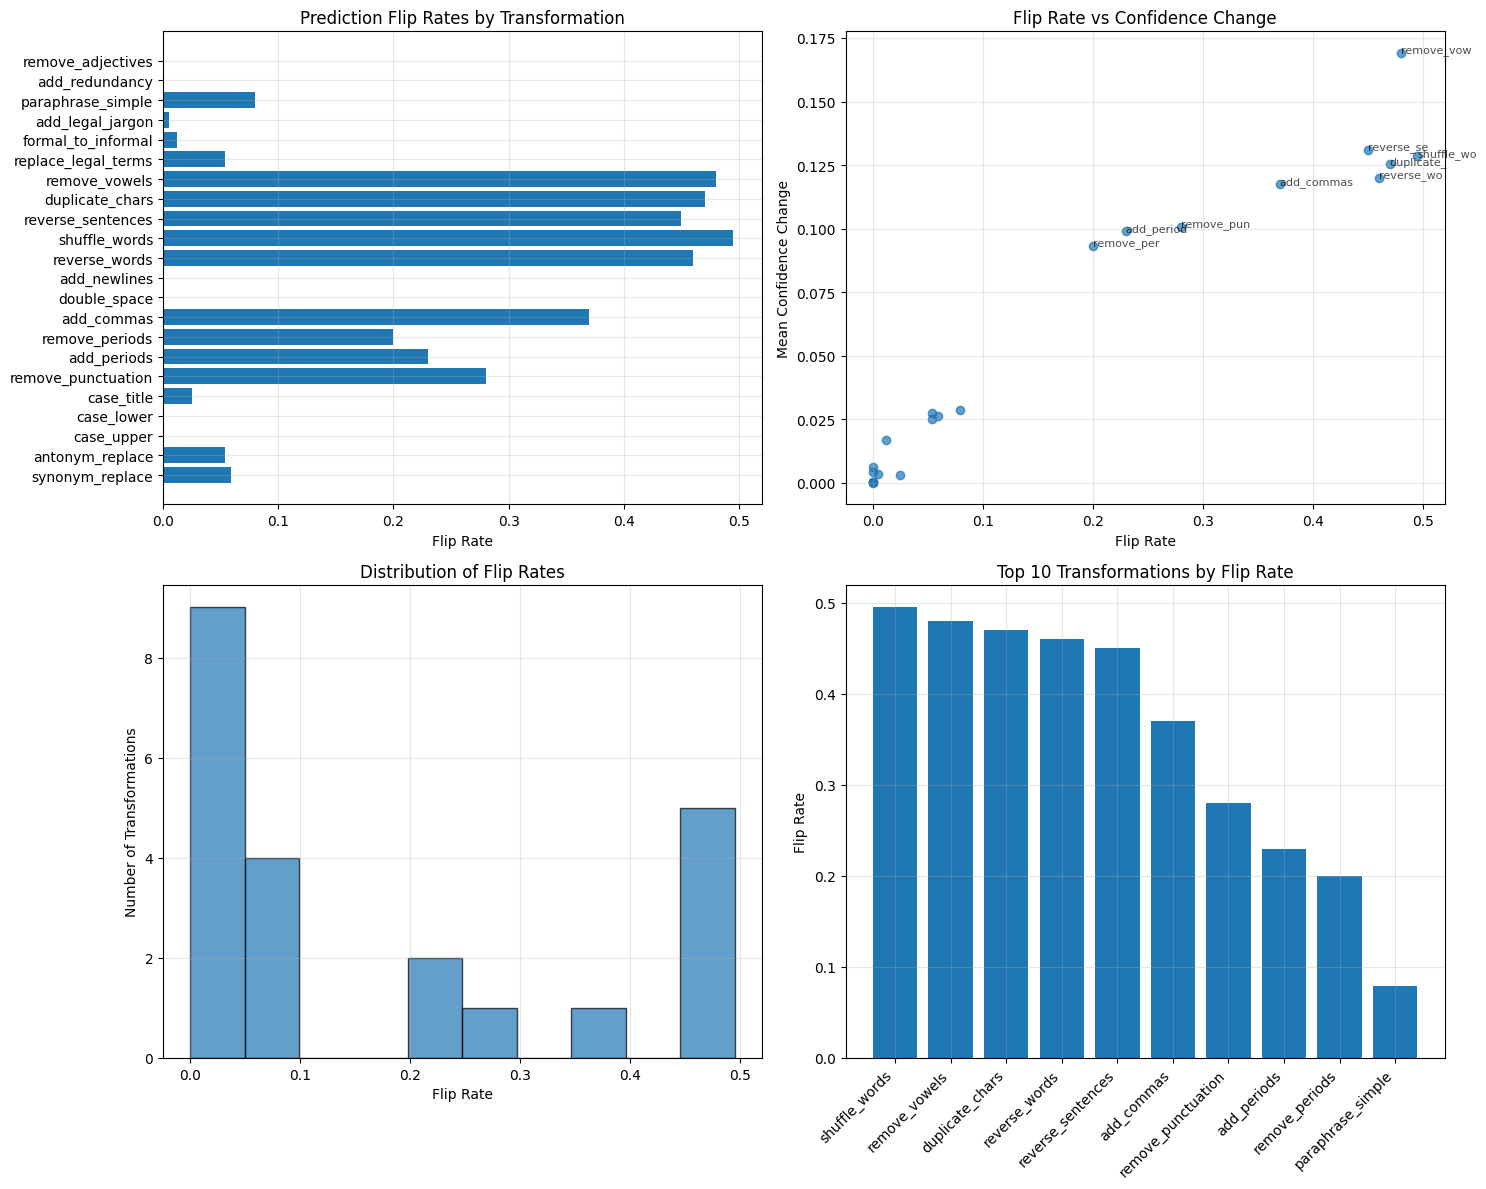


Results saved to 'flip_rate_results.json'


In [6]:
flip_results, sorted_results = enhanced_main_with_flip_analysis()


In [ ]:
# ================= Setup and Extended Noise Testing =================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from tqdm import tqdm
import shap
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def extended_noise_vulnerability_test(model, tokenizer, test_sentences, 
                                    noise_levels=np.arange(0.01, 0.3, 0.02),
                                    n_samples=50):
    """
    Extended noise vulnerability testing with more noise levels and samples
    """
    print(f"Testing noise vulnerability across {len(noise_levels)} noise levels...")
    
    # CRITICAL FIX: Set model to evaluation mode
    model.eval()
    
    results = {
        'noise_levels': [],
        'mean_shap_diff': [],
        'std_shap_diff': [],
        'prediction_flips': [],
        'flip_rates': [],
        'confidence_drops': [],
        'max_shap_diff': [],
        'min_shap_diff': []
    }
    
    base_predict_fn = create_predict_function(model, tokenizer)
    base_explainer = shap.Explainer(base_predict_fn, shap.maskers.Text(tokenizer))
    
    # Get baseline predictions and SHAP values
    baseline_predictions = []
    baseline_confidences = []
    baseline_shap_values = []
    
    sample_sentences = test_sentences[:n_samples]
    
    print("Computing baseline values...")
    for sentence in tqdm(sample_sentences):
        try:
            pred_result = base_predict_fn([sentence])
            baseline_predictions.append(pred_result.argmax())
            baseline_confidences.append(pred_result.max())
            
            shap_values = base_explainer([sentence])
            baseline_shap_values.append(shap_values[0].values)
        except Exception as e:
            print(f"Error with sentence: {e}")
            continue
    
    for noise_std in tqdm(noise_levels, desc="Testing noise levels"):
        def noisy_predict_fn(texts):
            if isinstance(texts, np.ndarray):
                texts = texts.tolist()
            inputs = tokenizer(texts, return_tensors="pt", padding=True, 
                             truncation=True, max_length=512, return_token_type_ids=False)
            
            # Get device from model
            device = next(model.parameters()).device
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            # Ensure model is in eval mode
            model.eval()
            
            with torch.no_grad():
                embeddings = model.bert.embeddings(input_ids=inputs['input_ids'])
                noise = torch.randn_like(embeddings) * noise_std
                noisy_embeddings = embeddings + noise
                
                encoder_outputs = model.bert.encoder(noisy_embeddings)
                sequence_output = encoder_outputs[0]
                
                pooled_output, _ = model.attention_pooling(
                    sequence_output, sequence_output, sequence_output,
                    key_padding_mask=~inputs['attention_mask'].bool()
                )
                pooled_output = pooled_output.mean(dim=1)
                pooled_output = model.layer_norm(pooled_output)
                
                x = pooled_output
                for layer in model.classifier_layers:
                    x = layer(x)
                logits = model.final_classifier(x)
                probs = torch.nn.functional.softmax(logits, dim=1)
            return probs.cpu().numpy()
        
        noisy_explainer = shap.Explainer(noisy_predict_fn, shap.maskers.Text(tokenizer))
        
        shap_differences = []
        prediction_flips = 0
        confidence_drops = []
        
        for i, sentence in enumerate(sample_sentences[:len(baseline_predictions)]):
            try:
                # Get noisy predictions
                noisy_pred_result = noisy_predict_fn([sentence])
                noisy_pred = noisy_pred_result.argmax()
                noisy_confidence = noisy_pred_result.max()
                
                # Check prediction flip
                if baseline_predictions[i] != noisy_pred:
                    prediction_flips += 1
                
                # Calculate confidence drop
                confidence_drop = baseline_confidences[i] - noisy_confidence
                confidence_drops.append(confidence_drop)
                
                # Get SHAP differences
                noisy_shap = noisy_explainer([sentence])
                base_vals = baseline_shap_values[i]
                noisy_vals = noisy_shap[0].values
                
                # Handle different lengths
                min_len = min(len(base_vals), len(noisy_vals))
                if min_len > 0:
                    diff = np.abs(base_vals[:min_len] - noisy_vals[:min_len])
                    shap_differences.extend(diff)
                
            except Exception as e:
                continue
        
        # Store results
        results['noise_levels'].append(noise_std)
        results['mean_shap_diff'].append(np.mean(shap_differences) if shap_differences else 0)
        results['std_shap_diff'].append(np.std(shap_differences) if shap_differences else 0)
        results['prediction_flips'].append(prediction_flips)
        results['flip_rates'].append(prediction_flips / len(baseline_predictions))
        results['confidence_drops'].append(np.mean(confidence_drops) if confidence_drops else 0)
        results['max_shap_diff'].append(np.max(shap_differences) if shap_differences else 0)
        results['min_shap_diff'].append(np.min(shap_differences) if shap_differences else 0)
    
    return results

# Alternative: Create a safer predict function that handles batch size issues
def create_safe_predict_function(model, tokenizer):
    """
    Create a predict function that handles single samples safely
    """
    def predict_fn(texts):
        if isinstance(texts, str):
            texts = [texts]
        elif isinstance(texts, np.ndarray):
            texts = texts.tolist()
        
        # Ensure we have at least 2 samples for batch norm
        original_length = len(texts)
        if len(texts) == 1:
            texts = texts + texts  # Duplicate the single text
        
        inputs = tokenizer(texts, return_tensors="pt", padding=True, 
                         truncation=True, max_length=512, return_token_type_ids=False)
        
        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        model.eval()  # Ensure eval mode
        
        with torch.no_grad():
            embeddings = model.bert.embeddings(input_ids=inputs['input_ids'])
            encoder_outputs = model.bert.encoder(embeddings)
            sequence_output = encoder_outputs[0]
            
            pooled_output, _ = model.attention_pooling(
                sequence_output, sequence_output, sequence_output,
                key_padding_mask=~inputs['attention_mask'].bool()
            )
            pooled_output = pooled_output.mean(dim=1)
            pooled_output = model.layer_norm(pooled_output)
            
            x = pooled_output
            for layer in model.classifier_layers:
                x = layer(x)
            logits = model.final_classifier(x)
            probs = torch.nn.functional.softmax(logits, dim=1)
        
        # Return only the original number of predictions
        return probs[:original_length].cpu().numpy()
    
    return predict_fn

# Run extended noise testing
try:
    # Load model if not already loaded
    if 'model' not in locals():
        model, tokenizer, config = ModelSaver.load_model("./final_model_checkpoint")
    
    # CRITICAL FIX: Set model to evaluation mode
    model.eval()
    
    # Update create_predict_function to use the safe version
    create_predict_function = create_safe_predict_function
    
    # Get test sentences (assuming df_test exists from previous cell)
    if 'df_test' not in locals():
        print("df_test not found. Creating sample sentences...")
        test_sentences = [
            "The petition is allowed after thorough examination of evidence.",
            "The court dismisses the application due to insufficient grounds.",
            "Relief is granted considering the compelling arguments presented.",
            "The motion is denied as it lacks legal merit.",
            "After review, the court finds the petition has substance."
        ] * 10  # Repeat to get more samples
    else:
        test_sentences = df_test['text'].tolist()
    
    noise_results = extended_noise_vulnerability_test(model, tokenizer, test_sentences)
    print("Extended noise testing completed!")
    
except Exception as e:
    print(f"Error in noise testing: {e}")
    print("Make sure the model is trained and saved first.")

# ================= Comprehensive Noise Attack Visualizations =================

def plot_noise_attack_results(results):
    """
    Create comprehensive plots for noise attack results
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Noise Attack Vulnerability Analysis', fontsize=16, fontweight='bold')
    
    # Plot 1: SHAP Value Changes
    axes[0, 0].plot(results['noise_levels'], results['mean_shap_diff'], 'b-', linewidth=2, label='Mean')
    axes[0, 0].fill_between(results['noise_levels'], 
                           np.array(results['mean_shap_diff']) - np.array(results['std_shap_diff']),
                           np.array(results['mean_shap_diff']) + np.array(results['std_shap_diff']),
                           alpha=0.3, color='blue')
    axes[0, 0].plot(results['noise_levels'], results['max_shap_diff'], 'r--', alpha=0.7, label='Max')
    axes[0, 0].set_xlabel('Noise Level (σ)')
    axes[0, 0].set_ylabel('SHAP Value Difference')
    axes[0, 0].set_title('SHAP Stability vs Noise Level')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Prediction Flip Rate
    axes[0, 1].plot(results['noise_levels'], results['flip_rates'], 'ro-', linewidth=2, markersize=4)
    axes[0, 1].set_xlabel('Noise Level (σ)')
    axes[0, 1].set_ylabel('Prediction Flip Rate')
    axes[0, 1].set_title('Prediction Stability vs Noise Level')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Confidence Drop
    axes[0, 2].plot(results['noise_levels'], results['confidence_drops'], 'g^-', linewidth=2, markersize=4)
    axes[0, 2].set_xlabel('Noise Level (σ)')
    axes[0, 2].set_ylabel('Average Confidence Drop')
    axes[0, 2].set_title('Confidence Degradation vs Noise Level')
    axes[0, 2].grid(True, alpha=0.3)
    
    # Plot 4: Cumulative Flip Rate
    cumulative_flips = np.cumsum(results['prediction_flips'])
    axes[1, 0].plot(results['noise_levels'], cumulative_flips, 'mo-', linewidth=2, markersize=4)
    axes[1, 0].set_xlabel('Noise Level (σ)')
    axes[1, 0].set_ylabel('Cumulative Prediction Flips')
    axes[1, 0].set_title('Cumulative Prediction Instability')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: SHAP Variance
    shap_variance = np.array(results['std_shap_diff']) ** 2
    axes[1, 1].plot(results['noise_levels'], shap_variance, 'co-', linewidth=2, markersize=4)
    axes[1, 1].set_xlabel('Noise Level (σ)')
    axes[1, 1].set_ylabel('SHAP Variance')
    axes[1, 1].set_title('SHAP Explanation Variance')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Plot 6: Vulnerability Heatmap
    vulnerability_matrix = np.array([
        results['flip_rates'],
        np.array(results['mean_shap_diff']) / np.max(results['mean_shap_diff']),
        np.array(results['confidence_drops']) / np.max(results['confidence_drops'])
    ])
    
    im = axes[1, 2].imshow(vulnerability_matrix, cmap='Reds', aspect='auto', interpolation='nearest')
    axes[1, 2].set_xlabel('Noise Level Index')
    axes[1, 2].set_ylabel('Vulnerability Metric')
    axes[1, 2].set_title('Vulnerability Heatmap')
    axes[1, 2].set_yticks([0, 1, 2])
    axes[1, 2].set_yticklabels(['Flip Rate', 'SHAP Diff', 'Conf. Drop'])
    
    # Add colorbar
    plt.colorbar(im, ax=axes[1, 2], shrink=0.8)
    
    plt.tight_layout()
    plt.savefig('noise_attack_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# Generate plots
if 'noise_results' in locals():
    plot_noise_attack_results(noise_results)
else:
    print("Run the noise testing first to generate plots.")

# ================= Individual SHAP Visualizations =================

def visualize_shap_comparison(model, tokenizer, sentence, noise_levels=[0.0, 0.05, 0.1, 0.2]):
    """
    Visualize SHAP values for the same sentence under different noise levels
    """
    # Set model to evaluation mode
    model.eval()
    
    fig, axes = plt.subplots(len(noise_levels), 1, figsize=(15, 4*len(noise_levels)))
    if len(noise_levels) == 1:
        axes = [axes]
    
    for i, noise_std in enumerate(noise_levels):
        # Create prediction function with specific noise level
        if noise_std == 0.0:
            predict_fn = create_safe_predict_function(model, tokenizer)
            title = f"SHAP Values - No Noise (Baseline)"
        else:
            def noisy_predict_fn(texts):
                if isinstance(texts, str):
                    texts = [texts]
                elif isinstance(texts, np.ndarray):
                    texts = texts.tolist()
                
                # Handle single sample issue
                original_length = len(texts)
                if len(texts) == 1:
                    texts = texts + texts
                
                inputs = tokenizer(texts, return_tensors="pt", padding=True, 
                                 truncation=True, max_length=512, return_token_type_ids=False)
                
                device = next(model.parameters()).device
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                model.eval()  # Ensure eval mode
                
                with torch.no_grad():
                    embeddings = model.bert.embeddings(input_ids=inputs['input_ids'])
                    noise = torch.randn_like(embeddings) * noise_std
                    noisy_embeddings = embeddings + noise
                    
                    encoder_outputs = model.bert.encoder(noisy_embeddings)
                    sequence_output = encoder_outputs[0]
                    
                    pooled_output, _ = model.attention_pooling(
                        sequence_output, sequence_output, sequence_output,
                        key_padding_mask=~inputs['attention_mask'].bool()
                    )
                    pooled_output = pooled_output.mean(dim=1)
                    pooled_output = model.layer_norm(pooled_output)
                    
                    x = pooled_output
                    for layer in model.classifier_layers:
                        x = layer(x)
                    logits = model.final_classifier(x)
                    probs = torch.nn.functional.softmax(logits, dim=1)
                
                return probs[:original_length].cpu().numpy()
            
            predict_fn = noisy_predict_fn
            title = f"SHAP Values - Noise σ={noise_std:.2f}"
        
        # Generate SHAP values
        try:
            explainer = shap.Explainer(predict_fn, shap.maskers.Text(tokenizer))
            shap_values = explainer([sentence])
            
            # Create waterfall plot
            shap.plots.waterfall(shap_values[0][:, 1], show=False)  # Class 1 (positive)
            axes[i].set_title(title, fontsize=14, fontweight='bold')
            
        except Exception as e:
            print(f"Error generating SHAP plot for noise {noise_std}: {e}")
            axes[i].text(0.5, 0.5, f"Error: {str(e)}", ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(title, fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(f'shap_noise_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_shap_heatmap_comparison(model, tokenizer, sentences, noise_levels=[0.0, 0.1, 0.2]):
    """
    Create heatmap comparing SHAP values across sentences and noise levels
    """
    # Set model to evaluation mode
    model.eval()
    
    shap_data = defaultdict(list)
    
    for noise_std in tqdm(noise_levels, desc="Processing noise levels"):
        if noise_std == 0.0:
            predict_fn = create_safe_predict_function(model, tokenizer)
        else:
            def noisy_predict_fn(texts, noise_level=noise_std):
                if isinstance(texts, str):
                    texts = [texts]
                elif isinstance(texts, np.ndarray):
                    texts = texts.tolist()
                
                original_length = len(texts)
                if len(texts) == 1:
                    texts = texts + texts
                
                inputs = tokenizer(texts, return_tensors="pt", padding=True, 
                                 truncation=True, max_length=512, return_token_type_ids=False)
                
                device = next(model.parameters()).device
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                model.eval()
                
                with torch.no_grad():
                    embeddings = model.bert.embeddings(input_ids=inputs['input_ids'])
                    noise = torch.randn_like(embeddings) * noise_level
                    noisy_embeddings = embeddings + noise
                    
                    encoder_outputs = model.bert.encoder(noisy_embeddings)
                    sequence_output = encoder_outputs[0]
                    
                    pooled_output, _ = model.attention_pooling(
                        sequence_output, sequence_output, sequence_output,
                        key_padding_mask=~inputs['attention_mask'].bool()
                    )
                    pooled_output = pooled_output.mean(dim=1)
                    pooled_output = model.layer_norm(pooled_output)
                    
                    x = pooled_output
                    for layer in model.classifier_layers:
                        x = layer(x)
                    logits = model.final_classifier(x)
                    probs = torch.nn.functional.softmax(logits, dim=1)
                
                return probs[:original_length].cpu().numpy()
            
            predict_fn = noisy_predict_fn
        
        explainer = shap.Explainer(predict_fn, shap.maskers.Text(tokenizer))
        
        for sentence in sentences[:5]:  # Limit to 5 sentences for readability
            try:
                shap_values = explainer([sentence])
                # Store mean absolute SHAP value for this sentence/noise combination
                mean_shap = np.mean(np.abs(shap_values[0].values))
                shap_data[f"Noise_{noise_std:.2f}"].append(mean_shap)
            except Exception as e:
                print(f"Error with sentence at noise {noise_std}: {e}")
                shap_data[f"Noise_{noise_std:.2f}"].append(0)
    
    # Create DataFrame for heatmap
    df_heatmap = pd.DataFrame(shap_data)
    df_heatmap.index = [f"Sentence_{i+1}" for i in range(len(sentences[:5]))]
    
    # Plot heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_heatmap, annot=True, cmap='YlOrRd', fmt='.3f', cbar_kws={'label': 'Mean |SHAP Value|'})
    plt.title('SHAP Value Intensity Across Noise Levels', fontsize=14, fontweight='bold')
    plt.xlabel('Noise Level')
    plt.ylabel('Sentences')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('shap_heatmap_noise.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return df_heatmap

# Example usage for SHAP visualizations
try:
    if 'model' not in locals():
        model, tokenizer, config = ModelSaver.load_model("./final_model_checkpoint")
    
    # CRITICAL FIX: Set model to evaluation mode
    model.eval()
    
    # Select an interesting sentence for detailed analysis
    sample_sentence = "The court finds that the petition has merit and grants the requested relief based on compelling evidence."
    
    print("Generating SHAP comparison across noise levels...")
    visualize_shap_comparison(model, tokenizer, sample_sentence)
    
    # Create heatmap comparison
    sample_sentences = [
        "The petition is granted after careful consideration.",
        "The court dismisses the application without merit.",
        "Relief is denied due to insufficient evidence.",
        "The motion is allowed based on legal precedent.",
        "The appeal is rejected for lack of grounds."
    ]
    
    print("Creating SHAP intensity heatmap...")
    heatmap_df = create_shap_heatmap_comparison(model, tokenizer, sample_sentences)
    
except Exception as e:
    print(f"Error in SHAP visualization: {e}")

# ================= Advanced SHAP Attack Analysis =================

def analyze_shap_word_importance_shifts(model, tokenizer, sentence, noise_levels=[0.0, 0.05, 0.1, 0.15, 0.2]):
    """
    Analyze how word importance rankings change under noise
    """
    # CRITICAL FIX: Set model to evaluation mode
    model.eval()
    
    word_importance_data = {}
    
    # Tokenize sentence to get words
    tokens = tokenizer.tokenize(sentence)
    
    for noise_std in noise_levels:
        if noise_std == 0.0:
            predict_fn = create_safe_predict_function(model, tokenizer)
        else:
            def noisy_predict_fn(texts, noise_level=noise_std):
                if isinstance(texts, str):
                    texts = [texts]
                elif isinstance(texts, np.ndarray):
                    texts = texts.tolist()
                
                original_length = len(texts)
                if len(texts) == 1:
                    texts = texts + texts
                
                inputs = tokenizer(texts, return_tensors="pt", padding=True, 
                                 truncation=True, max_length=512, return_token_type_ids=False)
                
                device = next(model.parameters()).device
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                model.eval()
                
                with torch.no_grad():
                    embeddings = model.bert.embeddings(input_ids=inputs['input_ids'])
                    noise = torch.randn_like(embeddings) * noise_level
                    noisy_embeddings = embeddings + noise
                    
                    encoder_outputs = model.bert.encoder(noisy_embeddings)
                    sequence_output = encoder_outputs[0]
                    
                    pooled_output, _ = model.attention_pooling(
                        sequence_output, sequence_output, sequence_output,
                        key_padding_mask=~inputs['attention_mask'].bool()
                    )
                    pooled_output = pooled_output.mean(dim=1)
                    pooled_output = model.layer_norm(pooled_output)
                    
                    x = pooled_output
                    for layer in model.classifier_layers:
                        x = layer(x)
                    logits = model.final_classifier(x)
                    probs = torch.nn.functional.softmax(logits, dim=1)
                
                return probs[:original_length].cpu().numpy()
            
            predict_fn = noisy_predict_fn
        
        try:
            explainer = shap.Explainer(predict_fn, shap.maskers.Text(tokenizer))
            shap_values = explainer([sentence])
            
            # Get word importance (absolute SHAP values)
            word_importance = np.abs(shap_values[0].values)
            word_importance_data[f"noise_{noise_std:.2f}"] = word_importance
            
        except Exception as e:
            print(f"Error at noise {noise_std}: {e}")
            continue
    
    # Create visualization
    if word_importance_data:
        plt.figure(figsize=(15, 8))
        
        # Plot word importance across noise levels
        for i, (noise_level, importance) in enumerate(word_importance_data.items()):
            plt.plot(range(len(importance)), importance, 'o-', label=noise_level, alpha=0.7)
        
        plt.xlabel('Token Position')
        plt.ylabel('Absolute SHAP Value')
        plt.title('Word Importance Changes Across Noise Levels', fontsize=14, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Add token labels on x-axis (if not too many)
        if len(tokens) <= 20:
            plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')
        
        plt.tight_layout()
        plt.savefig('word_importance_shifts.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Create ranking stability analysis
        plt.figure(figsize=(12, 6))
        
        # Calculate ranking correlations
        baseline_importance = word_importance_data['noise_0.00']
        correlations = []
        noise_vals = []
        
        for noise_level, importance in word_importance_data.items():
            if noise_level != 'noise_0.00':
                corr = np.corrcoef(baseline_importance, importance)[0, 1]
                correlations.append(corr)
                noise_vals.append(float(noise_level.split('_')[1]))
        
        plt.plot(noise_vals, correlations, 'ro-', linewidth=2, markersize=6)
        plt.xlabel('Noise Level (σ)')
        plt.ylabel('Ranking Correlation with Baseline')
        plt.title('SHAP Ranking Stability Under Noise', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.ylim([0, 1])
        
        plt.tight_layout()
        plt.savefig('ranking_stability.png', dpi=300, bbox_inches='tight')
        plt.show()

# Run advanced analysis
try:
    if 'model' not in locals():
        model, tokenizer, config = ModelSaver.load_model("./final_model_checkpoint")
    
    # CRITICAL FIX: Set model to evaluation mode
    model.eval()
    
    analysis_sentence = "The court carefully reviewed all evidence and determined that the petition should be granted due to compelling legal arguments."
    
    print("Analyzing word importance shifts under noise...")
    analyze_shap_word_importance_shifts(model, tokenizer, analysis_sentence)
    
except Exception as e:
    print(f"Error in advanced analysis: {e}")

print("All noise attack and SHAP visualization experiments completed!")
print("Generated plots:")
print("- noise_attack_analysis.png: Comprehensive noise vulnerability analysis")
print("- shap_noise_comparison.png: SHAP values comparison across noise levels")
print("- shap_heatmap_noise.png: SHAP intensity heatmap")
print("- word_importance_shifts.png: Word importance changes")
print("- ranking_stability.png: SHAP ranking stability")

Testing noise vulnerability across 15 noise levels...
Computing baseline values...


  0%|          | 0/50 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1302 > 512). Running this sequence through the model will result in indexing errors


  2%|▏         | 1/50 [00:05<04:31,  5.55s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.88s/it]               
 10%|█         | 5/50 [00:58<07:24,  9.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.10s/it]               
 12%|█▏        | 6/50 [01:28<12:18, 16.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.93s/it]               
 14%|█▍        | 7/50 [01:54<14:11, 19.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.07s/it]               
 20%|██        | 10/50 [02:33<09:03, 13.59s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.64s/it]               
 24%|██▍       | 12/50 [02:53<07:11, 11.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.48s/it]               
 30%|███       | 15/50 [03:28<06:13, 10.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:45, 45.24s/it]               
PartitionExplainer explainer: 2it [00:11, 11.55s/it]               
 42%|████▏     | 21/50 [04:42<03:37,  7.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:38, 38.25s/it]               
 44%|████▍     | 22/50 [05:20<07:48, 16.75s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.68s/it]               
 46%|████▌     | 23/50 [05:42<08:12, 18.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.41s/it]               
PartitionExplainer explainer: 2it [00:12, 12.41s/it]               
 52%|█████▏    | 26/50 [06:11<05:06, 12.78s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.45s/it]               
 56%|█████▌    | 28/50 [06:36<04:14, 11.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.43s/it]               
 58%|█████▊    | 29/50 [07:03<05:43, 16.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.20s/it]               
 60%|██████    | 30/50 [07:32<06:38, 19.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.27s/it]               
 64%|██████▍   | 32/50 [07:57<04:43, 15.73s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.62s/it]               
 68%|██████▊   | 34/50 [08:16<03:06, 11.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.10s/it]               
 76%|███████▌  | 38/50 [08:51<01:36,  8.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.05s/it]               
 80%|████████  | 40/50 [09:24<01:53, 11.32s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:48, 48.06s/it]               
 82%|████████▏ | 41/50 [10:12<03:21, 22.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:44, 44.93s/it]               
PartitionExplainer explainer: 2it [00:10, 10.91s/it]               
 88%|████████▊ | 44/50 [11:15<01:54, 19.06s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.48s/it]               
 90%|█████████ | 45/50 [11:35<01:37, 19.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.40s/it]               
 92%|█████████▏| 46/50 [12:07<01:32, 23.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:35, 35.83s/it]               
 94%|█████████▍| 47/50 [12:43<01:20, 26.94s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.74s/it]               
 96%|█████████▌| 48/50 [13:05<00:50, 25.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:40, 40.06s/it]               
 98%|█████████▊| 49/50 [13:45<00:29, 29.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.42s/it]               
Testing noise levels:   0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.17s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.20s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.45s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.01s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.87s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.43s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.53s/it]               
PartitionExplainer explainer: 2it [00:11, 11.55s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:37, 37.70s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.43s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.42s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.55s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.46s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.49s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.31s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.11s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.47s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.85s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.25s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:48, 48.45s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:44, 44.62s/it]               
PartitionExplainer explainer: 2it [00:10, 10.81s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.61s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.33s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:35, 35.53s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.49s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:40, 40.25s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.78s/it]               
Testing noise levels:   7%|▋         | 1/15 [14:07<3:17:45, 847.51s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.43s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.58s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.55s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.51s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 15.00s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.60s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.73s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:11, 11.74s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:38, 38.23s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.36s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.46s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.99s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.83s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.62s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.62s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.54s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.83s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.12s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.15s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:47, 47.79s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:44, 44.84s/it]               
PartitionExplainer explainer: 2it [00:10, 10.90s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.58s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.44s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:35, 35.78s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.48s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:40, 40.34s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.04s/it]               
Testing noise levels:  13%|█▎        | 2/15 [28:21<3:04:27, 851.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.66s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.39s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.40s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.74s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.95s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.34s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:45, 45.76s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:11, 11.78s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:38, 38.06s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.41s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.48s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.91s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.51s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.75s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.25s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.27s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.42s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 22.00s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.14s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:48, 48.77s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:44, 44.93s/it]               
PartitionExplainer explainer: 2it [00:10, 10.86s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.53s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 32.00s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:35, 35.78s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.36s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:40, 40.13s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.16s/it]               
Testing noise levels:  20%|██        | 3/15 [42:31<2:50:09, 850.83s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.34s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:13, 13.94s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.50s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.69s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.69s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.82s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.99s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:45, 45.75s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:11, 11.96s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:38, 38.13s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.11s/it]               
PartitionExplainer explainer: 2it [00:12, 12.27s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:13, 13.14s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.03s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.19s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.50s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.34s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.41s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.92s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.40s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:50, 50.38s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.58s/it]               
PartitionExplainer explainer: 2it [00:10, 10.60s/it]               
PartitionExplainer explainer: 2it [00:20, 20.33s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.41s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:36, 36.02s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.20s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:41, 41.77s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.27s/it]               
Testing noise levels:  27%|██▋       | 4/15 [56:55<2:36:53, 855.79s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.28s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.07s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.78s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.86s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.67s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.05s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.09s/it]               
PartitionExplainer explainer: 2it [00:11, 11.59s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:38, 38.10s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.16s/it]               
PartitionExplainer explainer: 2it [00:12, 12.32s/it]               
PartitionExplainer explainer: 2it [00:12, 12.66s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.52s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.44s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.10s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.81s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:17, 17.12s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.46s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.00s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:48, 48.97s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:45, 45.38s/it]               
PartitionExplainer explainer: 2it [00:10, 10.66s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.99s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.36s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:35, 35.46s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.41s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:40, 40.12s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.94s/it]               
Testing noise levels:  33%|███▎      | 5/15 [1:11:04<2:22:13, 853.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.58s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.39s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.50s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.22s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.93s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.21s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.33s/it]               
PartitionExplainer explainer: 2it [00:11, 11.57s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:38, 38.07s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.17s/it]               
PartitionExplainer explainer: 2it [00:12, 12.35s/it]               
PartitionExplainer explainer: 2it [00:12, 12.85s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.96s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.45s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.62s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.18s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.57s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.67s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.79s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:48, 48.31s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:44, 44.65s/it]               
PartitionExplainer explainer: 2it [00:10, 10.70s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.31s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.12s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:35, 35.58s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.48s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:40, 40.12s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.69s/it]               
Testing noise levels:  40%|████      | 6/15 [1:25:10<2:07:37, 850.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.03s/it]               
PartitionExplainer explainer: 2it [00:10, 10.16s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.94s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.66s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.28s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.59s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.29s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.55s/it]               
PartitionExplainer explainer: 2it [00:11, 11.68s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:38, 38.46s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.26s/it]               
PartitionExplainer explainer: 2it [00:12, 12.34s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.72s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.38s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.43s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.64s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.22s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.22s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.37s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:33, 33.92s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:48, 48.75s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.72s/it]               
PartitionExplainer explainer: 2it [00:10, 10.87s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.51s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.24s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:36, 36.05s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.91s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:40, 40.12s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.77s/it]               
Testing noise levels:  47%|████▋     | 7/15 [1:39:29<1:53:49, 853.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.35s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.91s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.04s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.40s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.03s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.82s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.62s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.79s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:38, 38.17s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.36s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.70s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.97s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.35s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.00s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.80s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.19s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.51s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.95s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.14s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:48, 48.47s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:44, 44.91s/it]               
PartitionExplainer explainer: 2it [00:10, 10.73s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.79s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.34s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:35, 35.89s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.76s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:40, 40.34s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.40s/it]               
Testing noise levels:  53%|█████▎    | 8/15 [1:53:43<1:39:35, 853.60s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.31s/it]               
PartitionExplainer explainer: 2it [00:10, 10.17s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.65s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.81s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.80s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.05s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.73s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:55, 55.92s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.43s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:37, 37.41s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.83s/it]               
PartitionExplainer explainer: 2it [00:12, 12.34s/it]               
PartitionExplainer explainer: 2it [00:12, 12.59s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.70s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.39s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.22s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.09s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.61s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.73s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.15s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:48, 48.27s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:44, 44.67s/it]               
PartitionExplainer explainer: 2it [00:10, 10.82s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.73s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.12s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:36, 36.11s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.46s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:39, 39.03s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.83s/it]               
Testing noise levels:  60%|██████    | 9/15 [2:08:02<1:25:31, 855.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.22s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.06s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.25s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.77s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.58s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.83s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.28s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.02s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:42, 42.59s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.69s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.43s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.82s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.90s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.12s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.79s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.34s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.82s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.52s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.83s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:47, 47.90s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:44, 44.46s/it]               
PartitionExplainer explainer: 2it [00:10, 10.65s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.46s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.99s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:35, 35.91s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.22s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:42, 42.00s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.22s/it]               
Testing noise levels:  67%|██████▋   | 10/15 [2:22:24<1:11:27, 857.53s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.14s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.03s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.42s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.41s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.25s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.06s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:44, 44.81s/it]               
PartitionExplainer explainer: 2it [00:11, 11.60s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:37, 37.39s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.66s/it]               
PartitionExplainer explainer: 2it [00:12, 12.52s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:13, 13.06s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.01s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.08s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.76s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.42s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.46s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.40s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:26, 26.50s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:49, 49.72s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.51s/it]               
PartitionExplainer explainer: 2it [00:10, 10.85s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.51s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.57s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:35, 35.10s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.83s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:40, 40.25s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.41s/it]               
Testing noise levels:  73%|███████▎  | 11/15 [2:36:40<57:08, 857.16s/it]  

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.13s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.78s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.73s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.90s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.95s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.94s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.71s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:11, 11.71s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:39, 39.25s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.69s/it]               
PartitionExplainer explainer: 2it [00:12, 12.40s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.83s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.56s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.66s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.08s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.78s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.82s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.73s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.27s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:49, 49.70s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:45, 45.31s/it]               
PartitionExplainer explainer: 2it [00:10, 10.79s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.82s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.95s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:36, 36.98s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.93s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:39, 39.84s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.46s/it]               
Testing noise levels:  80%|████████  | 12/15 [2:50:58<42:51, 857.30s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.40s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.47s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.78s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.10s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:14, 14.82s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.63s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:47, 47.64s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:11, 11.91s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:40, 40.02s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.15s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.78s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:13, 13.01s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.92s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.61s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:29, 29.44s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.06s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:16, 16.85s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.01s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 12.71s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.44s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:48, 48.45s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:44, 44.81s/it]               
PartitionExplainer explainer: 2it [00:10, 10.88s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:20, 20.91s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:31, 31.65s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:35, 35.87s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.06s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:40, 40.43s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.02s/it]               
Testing noise levels:  87%|████████▋ | 13/15 [3:05:23<28:38, 859.49s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.66s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.14s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:25, 25.75s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:24, 24.61s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:15, 15.61s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.86s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:46, 46.78s/it]               
PartitionExplainer explainer: 2it [00:11, 11.67s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:38, 38.78s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:22, 22.22s/it]               
PartitionExplainer explainer: 2it [00:12, 12.57s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:12, 13.00s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:23, 23.04s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:28, 28.20s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:30, 30.44s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:19, 19.44s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:17, 17.05s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:21, 21.99s/it]               


  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:27, 27.17s/it]               


In [5]:
# ================= Interactive SHAP Dashboard =================

import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import numpy as np
import shap

def create_interactive_shap_explorer(model, tokenizer, test_sentences):
    """
    Create an interactive widget for exploring SHAP values under different conditions
    """
    # Use first 5 sentences from test_sentences for quick testing
    sample_sentences = test_sentences[:5] if len(test_sentences) >= 5 else test_sentences
    
    # Create widgets
    sentence_dropdown = widgets.Dropdown(
        options=[(f"Sample {i+1}: {sent[:60]}...", sent) for i, sent in enumerate(sample_sentences)],
        description='Sentence:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='800px')
    )
    
    custom_text = widgets.Textarea(
        placeholder='Or enter your own legal text here...',
        description='Custom Text:',
        style={'description_width': 'initial'},
        layout=widgets.Layout(width='800px', height='100px')
    )
    
    noise_slider = widgets.FloatSlider(
        value=0.0,
        min=0.0,
        max=0.3,
        step=0.01,
        description='Noise Level:',
        style={'description_width': 'initial'}
    )
    
    analysis_type = widgets.Dropdown(
        options=['Waterfall Plot', 'Bar Plot', 'Text Highlighting', 'Force Plot'],
        description='Plot Type:',
        style={'description_width': 'initial'}
    )
    
    analyze_button = widgets.Button(
        description='Analyze SHAP',
        button_style='primary',
        layout=widgets.Layout(width='200px')
    )
    
    output = widgets.Output()
    
    def on_analyze_click(b):
        with output:
            clear_output(wait=True)
            
            # Get text to analyze
            if custom_text.value.strip():
                text = custom_text.value.strip()
            else:
                text = sentence_dropdown.value
            
            noise_level = noise_slider.value
            plot_type = analysis_type.value
            
            print(f"Analyzing: {text[:100]}...")
            print(f"Noise level: {noise_level}")
            print(f"Plot type: {plot_type}")
            print("-" * 50)
            
            try:
                # Create prediction function
                if noise_level == 0.0:
                    predict_fn = create_predict_function(model, tokenizer)
                else:
                    def noisy_predict_fn(texts):
                        if isinstance(texts, np.ndarray):
                            texts = texts.tolist()
                        inputs = tokenizer(texts, return_tensors="pt", padding=True, 
                                         truncation=True, max_length=512, return_token_type_ids=False)
                        inputs = {k: v.to(device) for k, v in inputs.items()}
                        
                        with torch.no_grad():
                            embeddings = model.bert.embeddings(input_ids=inputs['input_ids'])
                            noise = torch.randn_like(embeddings) * noise_level
                            noisy_embeddings = embeddings + noise
                            
                            encoder_outputs = model.bert.encoder(noisy_embeddings)
                            sequence_output = encoder_outputs[0]
                            
                            pooled_output, _ = model.attention_pooling(
                                sequence_output, sequence_output, sequence_output,
                                key_padding_mask=~inputs['attention_mask'].bool()
                            )
                            pooled_output = pooled_output.mean(dim=1)
                            pooled_output = model.layer_norm(pooled_output)
                            
                            x = pooled_output
                            for layer in model.classifier_layers:
                                x = layer(x)
                            logits = model.final_classifier(x)
                            probs = torch.nn.functional.softmax(logits, dim=1)
                        return probs.cpu().numpy()
                    
                    predict_fn = noisy_predict_fn
                
                # Generate prediction and SHAP values
                prediction = predict_fn([text])
                pred_class = prediction.argmax()
                confidence = prediction.max()
                
                print(f"Prediction: {'POSITIVE' if pred_class == 1 else 'NEGATIVE'}")
                print(f"Confidence: {confidence:.3f}")
                print()
                
                explainer = shap.Explainer(predict_fn, shap.maskers.Text(tokenizer))
                shap_values = explainer([text])
                
                # Create visualization based on selected type
                plt.figure(figsize=(12, 6))
                
                if plot_type == 'Waterfall Plot':
                    shap.plots.waterfall(shap_values[0][:, pred_class], show=False)
                    plt.title(f'SHAP Waterfall Plot - Class {pred_class} (Noise: {noise_level})')
                
                elif plot_type == 'Bar Plot':
                    shap.plots.bar(shap_values[0][:, pred_class], show=False)
                    plt.title(f'SHAP Bar Plot - Class {pred_class} (Noise: {noise_level})')
                
                elif plot_type == 'Text Highlighting':
                    # Create a simple text highlighting plot
                    tokens = shap_values[0].data
                    values = shap_values[0].values
                    
                    plt.figure(figsize=(15, 3))
                    colors = ['red' if v < 0 else 'green' for v in values]
                    sizes = [abs(v) * 1000 + 10 for v in values]
                    
                    for i, (token, value, color, size) in enumerate(zip(tokens, values, colors, sizes)):
                        plt.scatter(i, 0, c=color, s=size, alpha=0.7)
                        plt.text(i, 0.1, token, rotation=45, ha='right', va='bottom', fontsize=8)
                    
                    plt.xlim(-1, len(tokens))
                    plt.ylim(-0.2, 0.5)
                    plt.xlabel('Token Position')
                    plt.title(f'SHAP Token Importance (Green=Positive, Red=Negative, Size=Magnitude)')
                    plt.grid(True, alpha=0.3)
                
                elif plot_type == 'Force Plot':
                    # Create force plot equivalent
                    shap.plots.force(shap_values[0][:, pred_class], show=False)
                    plt.title(f'SHAP Force Plot - Class {pred_class} (Noise: {noise_level})')
                
                plt.tight_layout()
                plt.show()
                
            except Exception as e:
                print(f"Error in analysis: {e}")
                import traceback
                traceback.print_exc()
    
    analyze_button.on_click(on_analyze_click)
    
    # Layout
    ui = widgets.VBox([
        widgets.HTML("<h3>Interactive SHAP Explorer</h3>"),
        sentence_dropdown,
        custom_text,
        widgets.HBox([noise_slider, analysis_type]),
        analyze_button,
        output
    ])
    
    display(ui)


In [ ]:
# ================= Robustness Metrics and Statistical Analysis =================

def compute_robustness_metrics(model, tokenizer, test_sentences, noise_levels=np.arange(0.0, 0.25, 0.05)):
    """
    Compute comprehensive robustness metrics
    """
    metrics = {
        'lipschitz_constant': [],
        'shap_stability_index': [],
        'prediction_consistency': [],
        'confidence_variance': [],
        'ranking_kendall_tau': []
    }
    
    print("Computing robustness metrics...")
    
    base_predict_fn = create_predict_function(model, tokenizer)
    base_explainer = shap.Explainer(base_predict_fn, shap.maskers.Text(tokenizer))
    
    # Get baseline values
    baseline_predictions = []
    baseline_confidences = []
    baseline_shap_values = []
    
    sample_sentences = test_sentences[:20]  # Use first 20 sentences for statistical significance
    
    for sentence in tqdm(sample_sentences, desc="Computing baselines"):
        try:
            pred = base_predict_fn([sentence])
            baseline_predictions.append(pred.argmax())
            baseline_confidences.append(pred.max())
            
            shap_vals = base_explainer([sentence])
            baseline_shap_values.append(shap_vals[0].values)
        except:
            continue
    
    for noise_std in tqdm(noise_levels[1:], desc="Computing metrics"):  # Skip 0.0 noise
        # Create noisy prediction function
        def noisy_predict_fn(texts):
            if isinstance(texts, np.ndarray):
                texts = texts.tolist()
            inputs = tokenizer(texts, return_tensors="pt", padding=True, 
                             truncation=True, max_length=512, return_token_type_ids=False)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                embeddings = model.bert.embeddings(input_ids=inputs['input_ids'])
                noise = torch.randn_like(embeddings) * noise_std
                noisy_embeddings = embeddings + noise
                
                encoder_outputs = model.bert.encoder(noisy_embeddings)
                sequence_output = encoder_outputs[0]
                
                pooled_output, _ = model.attention_pooling(
                    sequence_output, sequence_output, sequence_output,
                    key_padding_mask=~inputs['attention_mask'].bool()
                )
                pooled_output = pooled_output.mean(dim=1)
                pooled_output = model.layer_norm(pooled_output)
                
                x = pooled_output
                for layer in model.classifier_layers:
                    x = layer(x)
                logits = model.final_classifier(x)
                probs = torch.nn.functional.softmax(logits, dim=1)
            return probs.cpu().numpy()
        
        noisy_explainer = shap.Explainer(noisy_predict_fn, shap.maskers.Text(tokenizer))
        
        # Compute metrics for this noise level
        lipschitz_vals = []
        shap_stabilities = []
        pred_consistencies = []
        conf_variances = []
        ranking_taus = []
        
        for i, sentence in enumerate(sample_sentences[:len(baseline_predictions)]):
            try:
                # Noisy prediction
                noisy_pred = noisy_predict_fn([sentence])
                noisy_class = noisy_pred.argmax()
                noisy_conf = noisy_pred.max()
                
                # Noisy SHAP values
                noisy_shap = noisy_explainer([sentence])
                noisy_shap_vals = noisy_shap[0].values
                
                # 1. Lipschitz constant approximation
                conf_diff = abs(baseline_confidences[i] - noisy_conf)
                lipschitz_vals.append(conf_diff / noise_std if noise_std > 0 else 0)
                
                # 2. SHAP stability
                base_shap = baseline_shap_values[i]
                min_len = min(len(base_shap), len(noisy_shap_vals))
                if min_len > 0:
                    shap_diff = np.mean(np.abs(base_shap[:min_len] - noisy_shap_vals[:min_len]))
                    shap_stabilities.append(shap_diff)
                
                # 3. Prediction consistency
                pred_consistencies.append(1.0 if baseline_predictions[i] == noisy_class else 0.0)
                
                # 4. Confidence variance
                conf_variances.append((baseline_confidences[i] - noisy_conf) ** 2)
                
                # 5. Ranking correlation (Kendall's tau)
                if min_len > 0:
                    from scipy.stats import kendalltau
                    tau, _ = kendalltau(np.abs(base_shap[:min_len]), np.abs(noisy_shap_vals[:min_len]))
                    ranking_taus.append(tau if not np.isnan(tau) else 0)
                
            except Exception as e:
                continue
        
        # Store average metrics for this noise level
        metrics['lipschitz_constant'].append(np.mean(lipschitz_vals) if lipschitz_vals else 0)
        metrics['shap_stability_index'].append(np.mean(shap_stabilities) if shap_stabilities else 0)
        metrics['prediction_consistency'].append(np.mean(pred_consistencies) if pred_consistencies else 0)
        metrics['confidence_variance'].append(np.mean(conf_variances) if conf_variances else 0)
        metrics['ranking_kendall_tau'].append(np.mean(ranking_taus) if ranking_taus else 0)
    
    return metrics, noise_levels[1:]

def plot_robustness_metrics(metrics, noise_levels):
    """
    Plot comprehensive robustness metrics
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Model Robustness Metrics Under Noise Attacks', fontsize=16, fontweight='bold')
    
    # Plot 1: Lipschitz Constant
    axes[0, 0].plot(noise_levels, metrics['lipschitz_constant'], 'b-o', linewidth=2, markersize=5)
    axes[0, 0].set_xlabel('Noise Level (σ)')
    axes[0, 0].set_ylabel('Lipschitz Constant')
    axes[0, 0].set_title('Lipschitz Stability')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: SHAP Stability Index
    axes[0, 1].plot(noise_levels, metrics['shap_stability_index'], 'r-s', linewidth=2, markersize=5)
    axes[0, 1].set_xlabel('Noise Level (σ)')
    axes[0, 1].set_ylabel('SHAP Stability Index')
    axes[0, 1].set_title('SHAP Explanation Stability')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Prediction Consistency
    axes[0, 2].plot(noise_levels, metrics['prediction_consistency'], 'g-^', linewidth=2, markersize=5)
    axes[0, 2].set_xlabel('Noise Level (σ)')
    axes[0, 2].set_ylabel('Prediction Consistency')
    axes[0, 2].set_title('Prediction Stability')
    axes[0, 2].grid(True, alpha=0.3)
    axes[0, 2].set_ylim([0, 1])
    
    # Plot 4: Confidence Variance
    axes[1, 0].plot(noise_levels, metrics['confidence_variance'], 'm-d', linewidth=2, markersize=5)
    axes[1, 0].set_xlabel('Noise Level (σ)')
    axes[1, 0].set_ylabel('Confidence Variance')
    axes[1, 0].set_title('Confidence Stability')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 5: Ranking Correlation
    axes[1, 1].plot(noise_levels, metrics['ranking_kendall_tau'], 'c-p', linewidth=2, markersize=5)
    axes[1, 1].set_xlabel('Noise Level (σ)')
    axes[1, 1].set_ylabel('Kendall Tau')
    axes[1, 1].set_title('Feature Ranking Stability')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([-1, 1])
    
    # Plot 6: Combined Robustness Score
    # Normalize all metrics to [0, 1] and compute average
    normalized_metrics = {}
    for key, values in metrics.items():
        if key == 'ranking_kendall_tau':
            # Convert tau from [-1, 1] to [0, 1]
            normalized_metrics[key] = [(v + 1) / 2 for v in values]
        elif key == 'prediction_consistency':
            # Already in [0, 1]
            normalized_metrics[key] = values
        else:
            # Invert and normalize (lower is better for these metrics)
            max_val = max(values) if values else 1
            normalized_metrics[key] = [1 - (v / max_val) for v in values]
    
    # Compute combined score
    combined_score = []
    for i in range(len(noise_levels)):
        score = np.mean([
            normalized_metrics['lipschitz_constant'][i],
            normalized_metrics['shap_stability_index'][i],
            normalized_metrics['prediction_consistency'][i],
            normalized_metrics['confidence_variance'][i],
            normalized_metrics['ranking_kendall_tau'][i]
        ])
        combined_score.append(score)
    
    axes[1, 2].plot(noise_levels, combined_score, 'k-o', linewidth=3, markersize=6)
    axes[1, 2].set_xlabel('Noise Level (σ)')
    axes[1, 2].set_ylabel('Combined Robustness Score')
    axes[1, 2].set_title('Overall Robustness Score')
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig('robustness_metrics_comprehensive.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return combined_score


In [ ]:
# ================= Attack Success Rate Analysis =================

def analyze_attack_success_rates(model, tokenizer, test_sentences, attack_types=['noise', 'synonym', 'paraphrase']):
    """
    Analyze success rates of different types of attacks
    """
    attack_results = {}
    base_predict_fn = create_predict_function(model, tokenizer)
    
    # Get baseline predictions
    baseline_predictions = []
    baseline_confidences = []
    
    sample_sentences = test_sentences[:30]  # Use first 30 sentences from test_sentences
    
    for sentence in tqdm(sample_sentences, desc="Getting baselines"):
        try:
            pred = base_predict_fn([sentence])
            baseline_predictions.append(pred.argmax())
            baseline_confidences.append(pred.max())
        except:
            continue
    
    # Attack 1: Noise Attack (various levels)
    if 'noise' in attack_types:
        noise_levels = [0.05, 0.1, 0.15, 0.2, 0.25]
        noise_success_rates = []
        
        for noise_std in noise_levels:
            def noisy_predict_fn(texts):
                if isinstance(texts, np.ndarray):
                    texts = texts.tolist()
                inputs = tokenizer(texts, return_tensors="pt", padding=True, 
                                 truncation=True, max_length=512, return_token_type_ids=False)
                inputs = {k: v.to(device) for k, v in inputs.items()}
                
                with torch.no_grad():
                    embeddings = model.bert.embeddings(input_ids=inputs['input_ids'])
                    noise = torch.randn_like(embeddings) * noise_std
                    noisy_embeddings = embeddings + noise
                    
                    encoder_outputs = model.bert.encoder(noisy_embeddings)
                    sequence_output = encoder_outputs[0]
                    
                    pooled_output, _ = model.attention_pooling(
                        sequence_output, sequence_output, sequence_output,
                        key_padding_mask=~inputs['attention_mask'].bool()
                    )
                    pooled_output = pooled_output.mean(dim=1)
                    pooled_output = model.layer_norm(pooled_output)
                    
                    x = pooled_output
                    for layer in model.classifier_layers:
                        x = layer(x)
                    logits = model.final_classifier(x)
                    probs = torch.nn.functional.softmax(logits, dim=1)
                return probs.cpu().numpy()
            
            flips = 0
            for i, sentence in enumerate(sample_sentences[:len(baseline_predictions)]):
                try:
                    noisy_pred = noisy_predict_fn([sentence])
                    if noisy_pred.argmax() != baseline_predictions[i]:
                        flips += 1
                except:
                    continue
            
            success_rate = flips / len(baseline_predictions)
            noise_success_rates.append(success_rate)
        
        attack_results['noise'] = {
            'levels': noise_levels,
            'success_rates': noise_success_rates
        }
    
    # Attack 2: Synonym Replacement
    if 'synonym' in attack_types:
        synonym_replacements = {
            'granted': ['allowed', 'approved', 'permitted', 'accepted'],
            'dismissed': ['rejected', 'denied', 'refused', 'declined'],
            'petition': ['application', 'request', 'appeal', 'motion'],
            'court': ['tribunal', 'judge', 'judicial body', 'bench'],
            'evidence': ['proof', 'testimony', 'documentation', 'facts']
        }
        
        synonym_success_rates = []
        replacement_counts = [1, 2, 3, 4, 5]  # Number of replacements
        
        for num_replacements in replacement_counts:
            flips = 0
            for i, sentence in enumerate(sample_sentences[:len(baseline_predictions)]):
                try:
                    # Apply synonym replacements
                    modified_sentence = sentence
                    replacements_made = 0
                    
                    for original, synonyms in synonym_replacements.items():
                        if original in modified_sentence.lower() and replacements_made < num_replacements:
                            synonym = np.random.choice(synonyms)
                            modified_sentence = modified_sentence.replace(original, synonym)
                            replacements_made += 1
                    
                    if modified_sentence != sentence:  # Only test if changes were made
                        pred = base_predict_fn([modified_sentence])
                        if pred.argmax() != baseline_predictions[i]:
                            flips += 1
                except:
                    continue
            
            success_rate = flips / len(baseline_predictions)
            synonym_success_rates.append(success_rate)
        
        attack_results['synonym'] = {
            'levels': replacement_counts,
            'success_rates': synonym_success_rates
        }
    
    # Attack 3: Paraphrase Attack (simple)
    if 'paraphrase' in attack_types:
        paraphrase_patterns = [
            (r'The court finds', 'It is determined by the court'),
            (r'is granted', 'shall be allowed'),
            (r'is dismissed', 'shall be rejected'),
            (r'petition', 'formal request'),
            (r'after consideration', 'following review')
        ]
        
        paraphrase_success_rates = []
        pattern_counts = [1, 2, 3, 4, 5]
        
        for num_patterns in pattern_counts:
            flips = 0
            for i, sentence in enumerate(sample_sentences[:len(baseline_predictions)]):
                try:
                    modified_sentence = sentence
                    patterns_applied = 0
                    
                    for pattern, replacement in paraphrase_patterns[:num_patterns]:
                        if patterns_applied < num_patterns:
                            modified_sentence = re.sub(pattern, replacement, modified_sentence, flags=re.IGNORECASE)
                            patterns_applied += 1
                    
                    if modified_sentence != sentence:
                        pred = base_predict_fn([modified_sentence])
                        if pred.argmax() != baseline_predictions[i]:
                            flips += 1
                except:
                    continue
            
            success_rate = flips / len(baseline_predictions)
            paraphrase_success_rates.append(success_rate)
        
        attack_results['paraphrase'] = {
            'levels': pattern_counts,
            'success_rates': paraphrase_success_rates
        }
    
    return attack_results

def plot_attack_success_rates(attack_results):
    """
    Plot success rates for different attack types
    """
    plt.figure(figsize=(15, 5))
    
    colors = ['red', 'blue', 'green', 'orange', 'purple']
    
    for i, (attack_type, results) in enumerate(attack_results.items()):
        plt.subplot(1, len(attack_results), i + 1)
        
        plt.plot(results['levels'], results['success_rates'], 
                'o-', color=colors[i], linewidth=2, markersize=6)
        
        plt.xlabel('Attack Intensity')
        plt.ylabel('Success Rate')
        plt.title(f'{attack_type.capitalize()} Attack Success Rate')
        plt.grid(True, alpha=0.3)
        plt.ylim([0, 1])
        
        # Add percentage labels
        for x, y in zip(results['levels'], results['success_rates']):
            plt.annotate(f'{y:.1%}', (x, y), textcoords="offset points", 
                        xytext=(0,10), ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('attack_success_rates.png', dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
def run_comprehensive_experiments(test_sentences):
    """
    Run all experiments and generate comprehensive report
    """
    try:
        # Load model
        if 'model' not in locals():
            model, tokenizer, config = ModelSaver.load_model("./final_model_checkpoint")
        
        print("=" * 60)
        print("COMPREHENSIVE ROBUSTNESS AND ATTACK ANALYSIS")
        print("=" * 60)
        
        # 1. Compute robustness metrics
        print("\n1. Computing robustness metrics...")
        metrics, noise_levels = compute_robustness_metrics(model, tokenizer, test_sentences)
        combined_scores = plot_robustness_metrics(metrics, noise_levels)
        
        # 2. Analyze attack success rates
        print("\n2. Analyzing attack success rates...")
        attack_results = analyze_attack_success_rates(model, tokenizer, test_sentences)
        plot_attack_success_rates(attack_results)
        
        # 3. Generate summary report
        print("\n3. Generating summary report...")
        
        print("\n" + "="*50)
        print("EXECUTIVE SUMMARY")
        print("="*50)
        
        # Robustness summary
        avg_robustness = np.mean(combined_scores)
        print(f"Overall Robustness Score: {avg_robustness:.3f}/1.000")
        
        if avg_robustness > 0.8:
            robustness_level = "HIGH"
        elif avg_robustness > 0.6:
            robustness_level = "MODERATE"
        else:
            robustness_level = "LOW"
        
        print(f"Robustness Level: {robustness_level}")
        
        # Attack success summary
        print(f"\nAttack Success Rates (at maximum intensity):")
        for attack_type, results in attack_results.items():
            max_success_rate = max(results['success_rates'])
            print(f"  {attack_type.capitalize()} Attack: {max_success_rate:.1%}")
        
        # Recommendations
        print(f"\nRECOMMENDATIONS:")
        if avg_robustness < 0.7:
            print("- Consider adversarial training to improve robustness")
            print("- Implement input preprocessing to detect attacks")
            print("- Use ensemble methods for more stable predictions")
        
        if any(max(results['success_rates']) > 0.3 for results in attack_results.values()):
            print("- High vulnerability to certain attacks detected")
            print("- Implement input sanitization mechanisms")
            print("- Consider confidence thresholding for uncertain predictions")
        
        print("\nGenerated visualizations:")
        print("- robustness_metrics_comprehensive.png")
        print("- attack_success_rates.png")
        
    except Exception as e:
        print(f"Error in comprehensive experiments: {e}")
        import traceback
        traceback.print_exc()

print("All experiment functions loaded successfully!")
print("\nTo run experiments, execute:")
print("1. run_comprehensive_experiments(test_sentences) - for full analysis")
print("2. create_interactive_shap_explorer(model, tokenizer, test_sentences) - for interactive exploration")

In [ ]:
# Temporal analysis and FGSM attack success rates
def plot_temporal_fgsm_analysis(fgsm_results, temporal_results):
    """
    Plot only temporal analysis and FGSM results
    """
    plt.figure(figsize=(15, 10))
    
    # Plot 1: FGSM Success Rate vs Epsilon
    plt.subplot(2, 3, 1)
    plt.plot(fgsm_results['epsilons'], fgsm_results['success_rates'], 'r-o', linewidth=2, markersize=6)
    plt.xlabel('Epsilon Value')
    plt.ylabel('Attack Success Rate')
    plt.title('FGSM Attack Success vs Epsilon')
    plt.grid(True, alpha=0.3)
    
    # Highlight optimal epsilon
    if fgsm_results['success_rates']:
        max_idx = np.argmax(fgsm_results['success_rates'])
        plt.axvline(x=fgsm_results['epsilons'][max_idx], color='red', linestyle='--', alpha=0.7)
        plt.text(fgsm_results['epsilons'][max_idx], fgsm_results['success_rates'][max_idx], 
                f'  Max: {fgsm_results["success_rates"][max_idx]:.2%}', 
                verticalalignment='bottom')
    
    # Plot 2: FGSM Confidence Drop
    plt.subplot(2, 3, 2)
    plt.plot(fgsm_results['epsilons'], fgsm_results['confidence_drops'], 'b-s', linewidth=2, markersize=6)
    plt.xlabel('Epsilon Value')
    plt.ylabel('Average Confidence Drop')
    plt.title('FGSM Confidence Impact')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Temporal - Cumulative flips over time
    plt.subplot(2, 3, 3)
    plt.plot(temporal_results['time_steps'], temporal_results['cumulative_flips'], 'g-o', linewidth=2)
    plt.xlabel('Time Step (Increasing Noise)')
    plt.ylabel('Cumulative Flipped Predictions')
    plt.title('Cumulative Prediction Instability')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Temporal - New flips per step
    plt.subplot(2, 3, 4)
    plt.bar(temporal_results['time_steps'], temporal_results['new_flips_per_step'], 
            color='orange', alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel('New Flips')
    plt.title('New Prediction Flips per Step')
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Temporal - Stability recovery
    plt.subplot(2, 3, 5)
    plt.plot(temporal_results['time_steps'], temporal_results['stability_recovery'], 'purple', 
             marker='s', linewidth=2)
    plt.xlabel('Time Step')
    plt.ylabel('Recovery Rate')
    plt.title('Stability Recovery Rate')
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Combined Analysis Summary
    plt.subplot(2, 3, 6)
    plt.axis('off')
    
    # Create summary statistics
    max_fgsm_success = max(fgsm_results['success_rates']) if fgsm_results['success_rates'] else 0
    optimal_epsilon = fgsm_results['epsilons'][np.argmax(fgsm_results['success_rates'])] if fgsm_results['success_rates'] else 0
    final_cumulative_flips = temporal_results['cumulative_flips'][-1] if temporal_results['cumulative_flips'] else 0
    max_new_flips = max(temporal_results['new_flips_per_step']) if temporal_results['new_flips_per_step'] else 0
    avg_recovery = np.mean(temporal_results['stability_recovery']) if temporal_results['stability_recovery'] else 0
    
    summary_text = f"""
    TEMPORAL & FGSM ANALYSIS SUMMARY
    
    FGSM Attack Results:
    Max Success Rate: {max_fgsm_success:.2%}
    Optimal Epsilon: {optimal_epsilon:.4f}
    Avg Confidence Drop: {np.mean(fgsm_results['confidence_drops']):.3f}
    
    Temporal Robustness:
    Total Cumulative Flips: {final_cumulative_flips}
    Max New Flips/Step: {max_new_flips}
    Avg Recovery Rate: {avg_recovery:.2%}
    
    Model Robustness Assessment:
    FGSM Vulnerability: {'HIGH' if max_fgsm_success > 0.5 else 'MODERATE' if max_fgsm_success > 0.2 else 'LOW'}
    Temporal Stability: {'LOW' if final_cumulative_flips > 7 else 'MODERATE' if final_cumulative_flips > 3 else 'HIGH'}
    """
    
    plt.text(0.05, 0.95, summary_text, transform=plt.gca().transAxes, 
             fontsize=10, verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.suptitle('Temporal Analysis and FGSM Attack Study', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('temporal_fgsm_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

# ================= MAIN EXECUTION FUNCTION (SIMPLIFIED) =================
def run_temporal_fgsm_experiments(model, tokenizer, test_sentences):
    """
    Run only temporal analysis and FGSM experiments
    """
    print("TEMPORAL ANALYSIS & FGSM EXPERIMENTS")
    print("=" * 50)
    
    # 1. FGSM Attacks
    print("\n1. Running FGSM attacks...")
    fgsm_results = test_fgsm_attacks(model, tokenizer, test_sentences)
    
    # 2. Temporal Robustness Analysis
    print("\n2. Running temporal robustness analysis...")
    temporal_results = temporal_robustness_test(model, tokenizer, test_sentences)
    
    # 3. Generate visualizations
    print("\n3. Generating visualizations...")
    plot_temporal_fgsm_analysis(fgsm_results, temporal_results)
    
    # 4. Generate focused report
    print("\n4. Generating focused report...")
    generate_temporal_fgsm_report(fgsm_results, temporal_results)
    
    return {
        'fgsm_results': fgsm_results,
        'temporal_results': temporal_results
    }

def generate_temporal_fgsm_report(fgsm_results, temporal_results):
    """
    Generate a focused report on temporal and FGSM analysis
    """
    print("\n" + "="*60)
    print("TEMPORAL & FGSM ROBUSTNESS ANALYSIS REPORT")
    print("="*60)
    
    # Executive Summary
    print("\nEXECUTIVE SUMMARY")
    print("-" * 30)
    
    max_fgsm_success = max(fgsm_results['success_rates']) if fgsm_results['success_rates'] else 0
    final_temporal_flips = temporal_results['cumulative_flips'][-1] if temporal_results['cumulative_flips'] else 0
    
    print(f"Maximum FGSM attack success rate: {max_fgsm_success:.2%}")
    print(f"Total temporal prediction flips: {final_temporal_flips}")
    
    # Overall robustness assessment
    fgsm_vulnerability = "HIGH" if max_fgsm_success > 0.5 else "MODERATE" if max_fgsm_success > 0.2 else "LOW"
    temporal_stability = "LOW" if final_temporal_flips > 7 else "MODERATE" if final_temporal_flips > 3 else "HIGH"
    
    print(f"FGSM vulnerability level: {fgsm_vulnerability}")
    print(f"Temporal stability level: {temporal_stability}")
    
    # FGSM Attack Analysis
    print(f"\n1. GRADIENT-BASED ATTACKS (FGSM)")
    print("-" * 30)
    
    optimal_epsilon = fgsm_results['epsilons'][np.argmax(fgsm_results['success_rates'])] if fgsm_results['success_rates'] else 0
    avg_conf_drop = np.mean(fgsm_results['confidence_drops']) if fgsm_results['confidence_drops'] else 0
    
    print(f"Optimal epsilon value: {optimal_epsilon:.4f}")
    print(f"Maximum attack success rate: {max_fgsm_success:.2%}")
    print(f"Average confidence drop: {avg_conf_drop:.3f}")
    
    # Show progression of attack success
    print(f"\nFGSM attack progression:")
    for i, (eps, success) in enumerate(zip(fgsm_results['epsilons'], fgsm_results['success_rates'])):
        if i % 2 == 0:  # Show every other epsilon for brevity
            status = "🔴" if success > 0.5 else "🟡" if success > 0.2 else "🟢"
            print(f"  ε={eps:.3f}: {success:.2%} {status}")
    
    # Temporal Analysis
    print(f"\n2. TEMPORAL ROBUSTNESS ANALYSIS")
    print("-" * 30)
    
    max_new_flips = max(temporal_results['new_flips_per_step']) if temporal_results['new_flips_per_step'] else 0
    avg_recovery = np.mean(temporal_results['stability_recovery']) if temporal_results['stability_recovery'] else 0
    
    print(f"Total cumulative flips: {final_temporal_flips}")
    print(f"Maximum new flips in single step: {max_new_flips}")
    print(f"Average stability recovery rate: {avg_recovery:.2%}")
    
    # Show temporal progression
    print(f"\nTemporal flip progression:")
    for step, (cumulative, new_flips) in enumerate(zip(temporal_results['cumulative_flips'], 
                                                      temporal_results['new_flips_per_step'])):
        if step % 2 == 0:  # Show every other step for brevity
            noise_level = 0.05 + (step * 0.01)
            print(f"  Step {step} (σ={noise_level:.3f}): {cumulative} total, {new_flips} new")
    
    # Risk Assessment
    print(f"\n3. RISK ASSESSMENT")
    print("-" * 30)
    
    risk_factors = []
    recommendations = []
    
    if max_fgsm_success > 0.3:
        risk_factors.append("🔴 HIGH: Vulnerable to gradient-based attacks")
        recommendations.append("Implement adversarial training with FGSM")
    
    if final_temporal_flips > 5:
        risk_factors.append("🟡 MODERATE: Temporal instability under noise")
        recommendations.append("Add input preprocessing/denoising")
    
    if avg_recovery < 0.3:
        risk_factors.append("🟡 MODERATE: Poor stability recovery")
        recommendations.append("Improve model regularization")
    
    if max_new_flips > 3:
        risk_factors.append("🟡 MODERATE: Sudden instability spikes")
        recommendations.append("Monitor for adversarial patterns")
    
    print("Identified Risk Factors:")
    if risk_factors:
        for risk in risk_factors:
            print(f"  {risk}")
    else:
        print("  🟢 No significant risk factors identified")
    
    print(f"\nRecommendations:")
    if recommendations:
        for i, rec in enumerate(recommendations, 1):
            print(f"  {i}. {rec}")
    else:
        print("  Model shows good robustness - continue monitoring")
    
    # Statistical Insights
    print(f"\n4. STATISTICAL INSIGHTS")
    print("-" * 30)
    
    # FGSM epsilon-success correlation
    if len(fgsm_results['epsilons']) > 2:
        from scipy.stats import spearmanr
        fgsm_corr, fgsm_p = spearmanr(fgsm_results['epsilons'], fgsm_results['success_rates'])
        print(f"FGSM epsilon-success correlation: r={fgsm_corr:.3f} (p={fgsm_p:.4f})")
    
    # Temporal noise-flip correlation
    noise_levels = [0.05 + (step * 0.01) for step in temporal_results['time_steps']]
    if len(noise_levels) > 2:
        temporal_corr, temporal_p = spearmanr(noise_levels, temporal_results['cumulative_flips'])
        print(f"Temporal noise-flip correlation: r={temporal_corr:.3f} (p={temporal_p:.4f})")
    
    # Implementation Priority
    print(f"\n5. IMPLEMENTATION PRIORITY")
    print("-" * 30)
    
    high_priority = any("HIGH" in risk for risk in risk_factors)
    moderate_priority = any("MODERATE" in risk for risk in risk_factors)
    
    if high_priority:
        print("  🔴 URGENT: Address high-risk vulnerabilities immediately")
        print("     Focus on adversarial training and gradient masking")
    elif moderate_priority:
        print("  🟡 MODERATE: Plan improvements in next development cycle")
        print("     Focus on input preprocessing and regularization")
    else:
        print("  🟢 LOW: Maintain current robustness with regular monitoring")
        print("     Continue periodic temporal and FGSM testing")
    
    print("\n" + "="*60)
    print("END OF FOCUSED REPORT")
    print("="*60)

# ================= TEMPORAL ROBUSTNESS ANALYSIS (UNCHANGED) =================
def temporal_robustness_test(model, tokenizer, test_sentences, time_steps=10):
    """
    Test how robustness changes over multiple attack iterations
    """
    results = {
        'time_steps': list(range(time_steps)),
        'cumulative_flips': [],
        'new_flips_per_step': [],
        'stability_recovery': []
    }
    
    base_predict_fn = create_predict_function(model, tokenizer)
    sample_sentences = test_sentences[:10]
    
    # Get baseline predictions
    baseline_preds = []
    for sentence in sample_sentences:
        try:
            pred = base_predict_fn([sentence])
            baseline_preds.append(pred.argmax())
        except:
            continue
    
    cumulative_flipped = set()
    
    for step in range(time_steps):
        noise_std = 0.05 + (step * 0.01)  # Gradually increasing noise
        
        def noisy_predict_fn(texts):
            if isinstance(texts, np.ndarray):
                texts = texts.tolist()
            inputs = tokenizer(texts, return_tensors="pt", padding=True, 
                             truncation=True, max_length=512, return_token_type_ids=False)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            
            with torch.no_grad():
                embeddings = model.bert.embeddings(input_ids=inputs['input_ids'])
                noise = torch.randn_like(embeddings) * noise_std
                noisy_embeddings = embeddings + noise
                
                encoder_outputs = model.bert.encoder(noisy_embeddings)
                sequence_output = encoder_outputs[0]
                
                # Use attention pooling or simple mean pooling
                if hasattr(model, 'attention_pooling'):
                    pooled_output = model.attention_pooling(
                        sequence_output, sequence_output, sequence_output,
                        key_padding_mask=~inputs['attention_mask'].bool()
                    )[0]
                    pooled_output = pooled_output.mean(dim=1)
                else:
                    # Fallback to mean pooling
                    pooled_output = sequence_output.mean(dim=1)
                pooled_output = model.layer_norm(pooled_output)
                
                x = pooled_output
                for layer in model.classifier_layers:
                    x = layer(x)
                logits = model.final_classifier(x)
                probs = torch.nn.functional.softmax(logits, dim=1)
            return probs.cpu().numpy()
        
        # Test current step
        step_flipped = set()
        for i, sentence in enumerate(sample_sentences[:len(baseline_preds)]):
            try:
                pred = noisy_predict_fn([sentence])
                if pred.argmax() != baseline_preds[i]:
                    step_flipped.add(i)
            except:
                continue
        
        # Update results
        new_flips = len(step_flipped - cumulative_flipped)
        cumulative_flipped.update(step_flipped)
        
        results['cumulative_flips'].append(len(cumulative_flipped))
        results['new_flips_per_step'].append(new_flips)
        
        # Check stability recovery (sentences that were flipped before but stable now)
        previously_flipped = cumulative_flipped - step_flipped
        recovery_rate = len(previously_flipped) / len(cumulative_flipped) if cumulative_flipped else 0
        results['stability_recovery'].append(recovery_rate)
    
    return results

print("Focused experiments module loaded successfully!")
print("\nAvailable experiments:")
print("1. run_temporal_fgsm_experiments(model, tokenizer, test_sentences)")
print("2. temporal_robustness_test(model, tokenizer, test_sentences)")
print("\nTo run focused experiments:")
print("results = run_temporal_fgsm_experiments(model, tokenizer, test_sentences)")